# Importing, Cleaning, and Exploring USDA Fruit Yearbook Time Series Data

* Data and description sourced from the [United States Department of Agriculture](https://www.ers.usda.gov/data-products/fruit-and-tree-nut-data/fruit-and-tree-nut-yearbook-tables/)

* The USDA Fruit and Tree Nut Yearbook tables contains almost four decades of time-series data for U.S. bearing acreage, production, prices, etc. for a variety of Fruit and Nut Tree crops.

* Here we import data from a collection of Fruit Tree Yearbook tables that look at bearing acreage, and yield per acre, for a time series ranging from 1980 through 2018.

* The formatting of the data in the CSV files is a bit messy, so we utilize a custom helper function to reformat the data so that it can be put in a form that is more conducive to plotting and time series analysis, and is able to be broken down by both State and crop.

In [1]:
import csv
import math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

%matplotlib inline

# a function that takes in the filename of a csv file exported from a USDA Fruit Yearbook table
# returns a 2D array containing the values for bearing acreage and yield per acre, broken down by state
# assumes that the yearbook table is one of the bearing acreage and yield per acre tables, broken down by state
def readCSV(filename):
    data = []
    with open(filename) as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data.append(row)
    
    return data


# read the yearbook tables for each of the three citrus crops                
data1 = readCSV('FruitYearbookCitrusFruit_CTables_Grapefruit.csv')
data2 = readCSV('FruitYearbookCitrusFruit_CTables_Lemons.csv')
data3 = readCSV('FruitYearbookCitrusFruit_CTables_Oranges.csv')


# helper function that takes in the data read from one of the Fruit Yearbook tables
# produces a cleaned up version of the table
# each row in the cleaned up data table has a season, state, bearing acreage, yield per acre, and potentially production
def getCleanYearbookData(data, start_row, end_row):
    
    # extract the states represented in this yearbook
    states = [string for string in data[1] if string != '' and string != ' ']
    
    # used to determine which state partition a read datum is placed into
    divisor = len(data[start_row]) // len(states)
    
    partitioned_rows = []
    
    for i in range(start_row, end_row + 1):    
        row = data[i]   
        if row[0] != '':
            year = row[0]
            
            # each row in the cleaned data set has a year (season), state, and the recorded metrics
            partitioned_row = [[year, state] for state in states]
            
            col_index = 0
            
            for col in row:         
                if col_index != 0 and col != '' and col != ' ':  
                    val_to_add = 0.0
                    
                    if col.find(',') != -1:
                        val_to_add = int(col.replace(',', ''))
                    elif col.find('na') == -1:  
                        val_to_add = float(col)
                                    
                    partitioned_row[math.ceil(col_index / divisor) - 1].append(val_to_add)
                
                col_index += 1
            
            partitioned_rows += partitioned_row
    
    return partitioned_rows

# get cleaned up versions of the data for each of the three crops
cleaned_data_grapefruit = getCleanYearbookData(data1, 8, 50)
cleaned_data_lemons = getCleanYearbookData(data2, 8, 50)
cleaned_data_oranges = getCleanYearbookData(data3, 8, 50)


In [2]:
from enum import Enum

# enum type for specifying the type of time series plot to be generated
class YearbookPlotType(Enum):
    YIELD_PER_ACRE = 1
    BEARING_ACREAGE = 2
    PRODUCTION = 3

# helper function that takes in one of the cleaned_datasets, and a string labelling the crop
# produces time series plots of yield per acre for the given crop accross all recorded states
def plot_time_series(dataset, crop, plot_type=YearbookPlotType.YIELD_PER_ACRE, states=None):
    
    if states == None:
        states = list(set([row[1] for row in dataset]))
    
    columns = 2
    rows = int(math.ceil(len(states) / columns))
    curr_subplot = 1
    
    plt.rcParams['figure.figsize'] = (20, 10)
    plt.rcParams['font.size'] = 10.0
    plt.rcParams['axes.labelsize'] = 'medium'
    
    for state in states:
        
        state_dataset = [row for row in dataset if row[1] == state]
        
        state_metric = []
        color_string = ''
        ylabel_string = ''
        
        if plot_type == YearbookPlotType.YIELD_PER_ACRE:
            state_metric += [row[3] for row in state_dataset]
            color_string += 'r-o'
            ylabel_string += 'Yield per Acre (Short tons)'
        elif plot_type == YearbookPlotType.BEARING_ACREAGE:
            state_metric += [row[2] for row in state_dataset]
            color_string += 'b-o'
            ylabel_string += 'Bearing Acreage (1k acres)'
        else:
            if crop != 'Lemons':
                state_metric += [row[3] * row[2] for row in state_dataset]
            else:
                state_metric += [row[4] for row in state_dataset]
            color_string += 'g-o'
            ylabel_string += 'Production (1k short tons)'
        
        year_strings = [row[0] for row in state_dataset]
        
        years = [int(year_string[:5]) for year_string in year_strings]
        
        title_string = ''
        
        if state == 'United States':
            title_string += crop + ' in the ' + state
        else:
            title_string += crop + ' in the State of ' + state
        
        plt.subplot(rows, columns, curr_subplot)
        plt.plot(years, state_metric, color_string)
        plt.title(title_string)
        plt.xlabel('Start Year of Season')
        plt.ylabel(ylabel_string)
        curr_subplot += 1
    
    plt.tight_layout()
    plt.show()

# Plotting Time Series for Grapefruit By State

- Here we generate time series plots of Yield per Acre, Bearing Acreage, and Production (YPA * BA) for Grapefruit
- We see that while Grapefruit production has remained fairly stable in the state of Texas over the past 18 years, production has declined significantly in other states.
- In the state of California, while yield per acre has remained in a fairly stable oscillation since the year 2000, bearing acreage has been at an historic low since 2005, after having declined by roughly 40% between the years 2000 and 2005, contributing to a relatively low overall production by historic standards.
- In the state of Florida, a roughly two-thirds reduction in overall production is evident between the 2003/2004 and 2004/2005 seasons, due to three hurricanes and a tropical storm having passed through the state in the months of August and September, as well as the overall destructive [2004 Atlantic Hurricane Season](https://en.wikipedia.org/wiki/2004_Atlantic_hurricane_season). 
- Whilst a slight recovery of Florida Grapefruit production is evident between the years of 2004 and 2006, grapefruit production has witnessed a steady decline between 2006 and 2017, largely due to crop destruction by [citrus greening disease](https://www.floridafarmbureau.org/hope-for-floridas-declining-citrus-industry/).
- In the state of Arizona, Grapefruit production underwent a steady decline between 1991 and 2009, until finally dropping to such low levels that the USDA has ceased recording census information for this crop since 2009.
- [Decline in overall grapefruit production in Arizona](https://tucson.com/business/local/az-citrus-industry-hangs-on-amid-long-term-decline/article_13e6e4d8-8070-52bf-9ab3-eed24249e558.html) is due both to a reduction in bearing acreage, as well as damage by pests such as the [Asian citrus psyllid](http://californiacitrusthreat.org/pest-disease), which spreads citrus greening disease.
- Bearing acreage in the state of Texas has two steep drops, one after 1983, and another after 1989, both due to [highly destructive December freezes](https://aggie-horticulture.tamu.edu/citrus/l2319.htm)

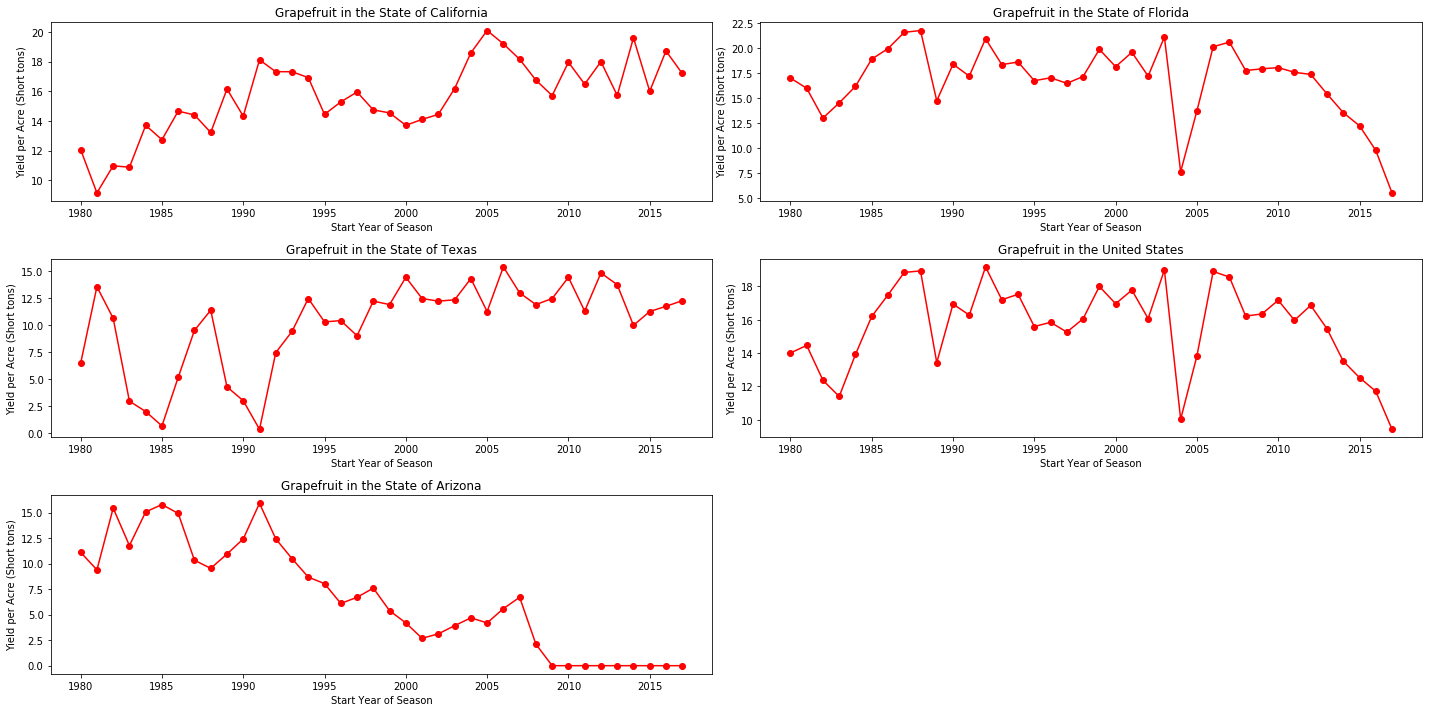

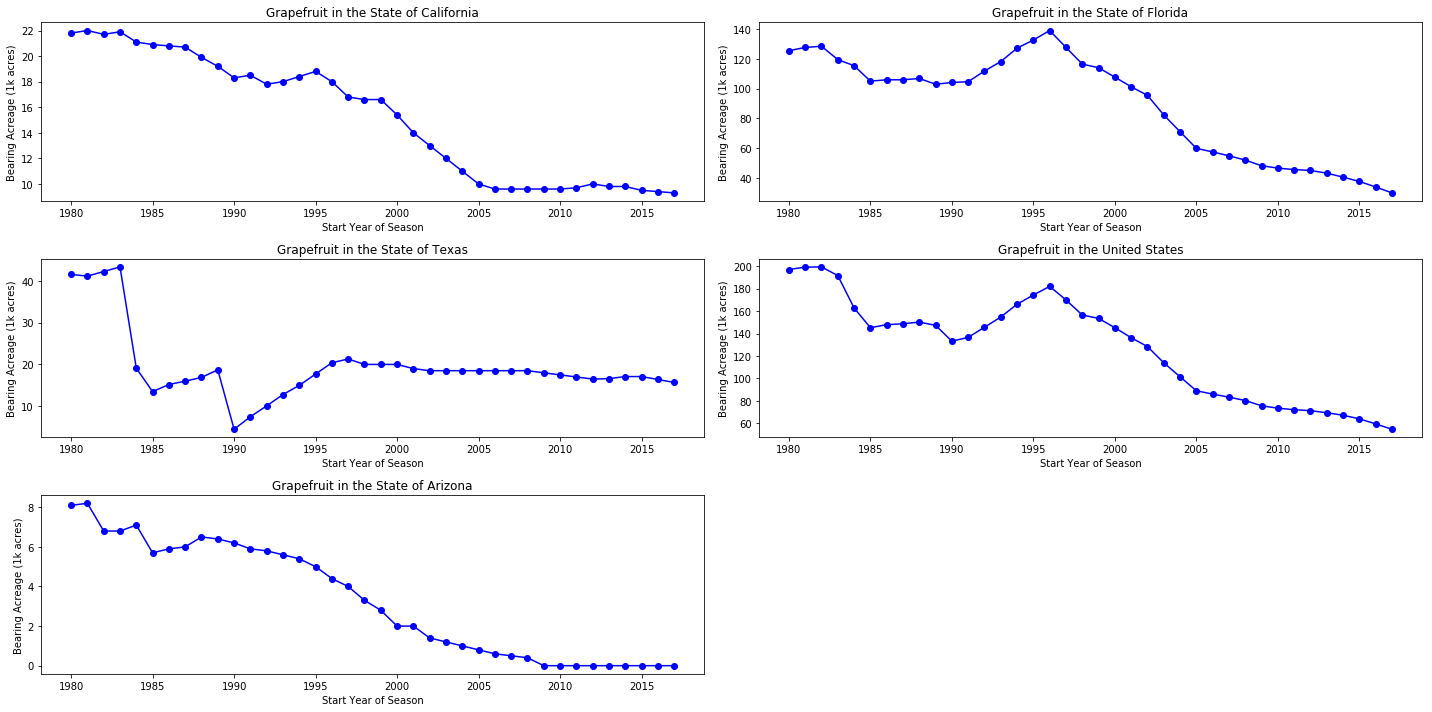

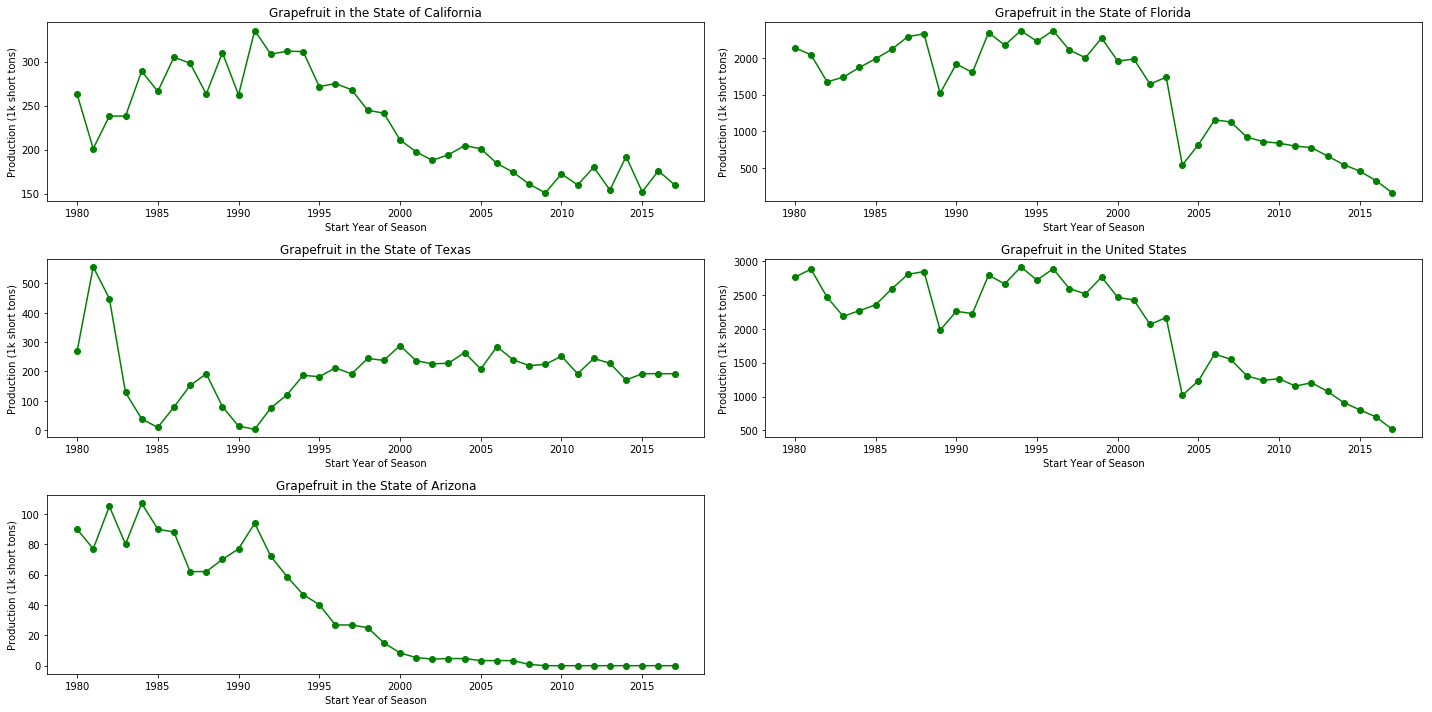

In [3]:
plot_time_series(cleaned_data_grapefruit, 'Grapefruit', YearbookPlotType.YIELD_PER_ACRE)
plot_time_series(cleaned_data_grapefruit, 'Grapefruit', YearbookPlotType.BEARING_ACREAGE)
plot_time_series(cleaned_data_grapefruit, 'Grapefruit', YearbookPlotType.PRODUCTION)

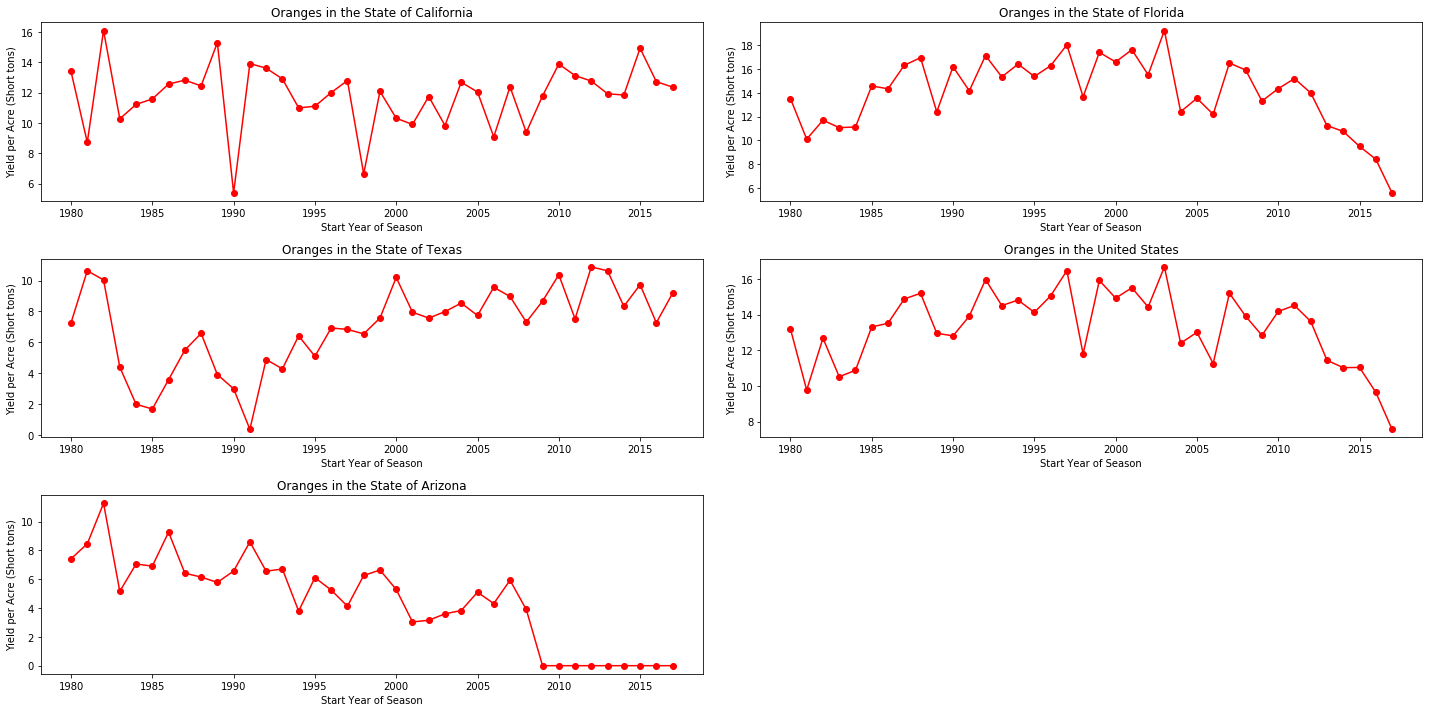

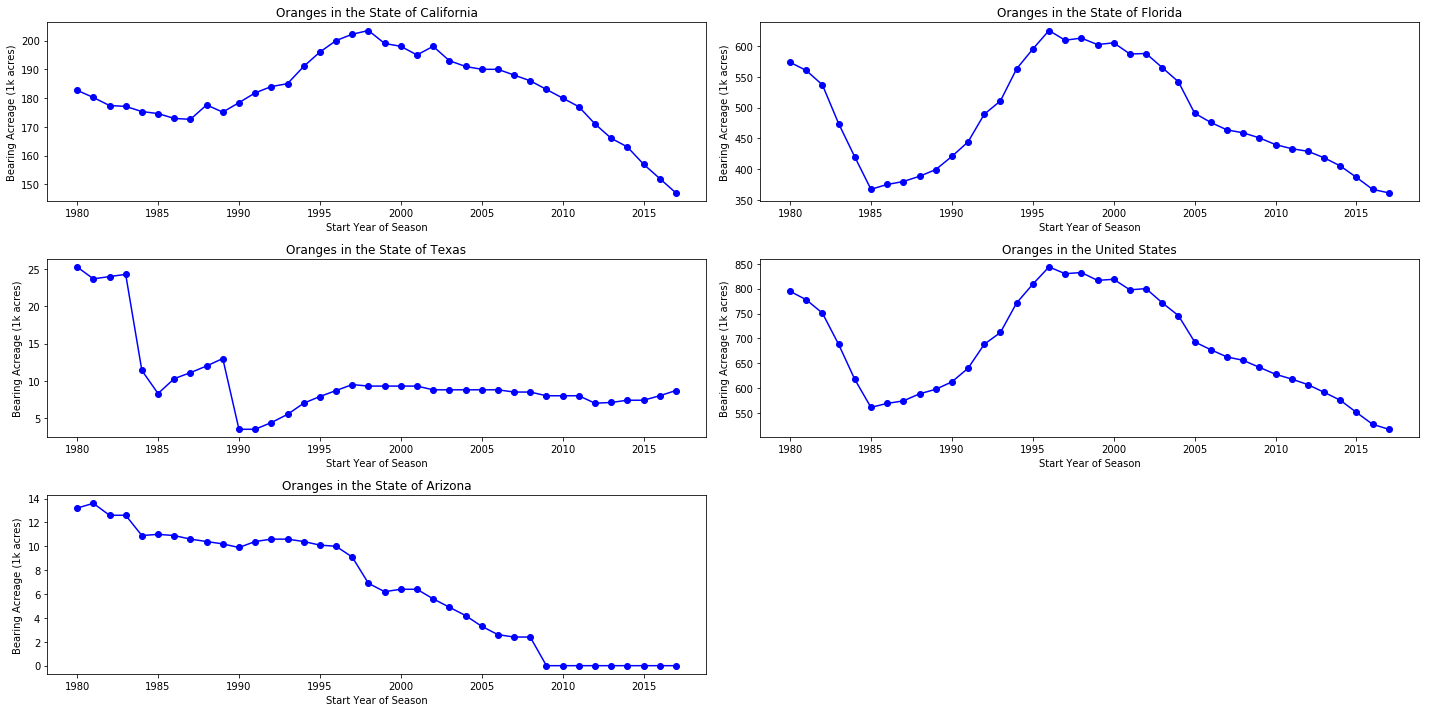

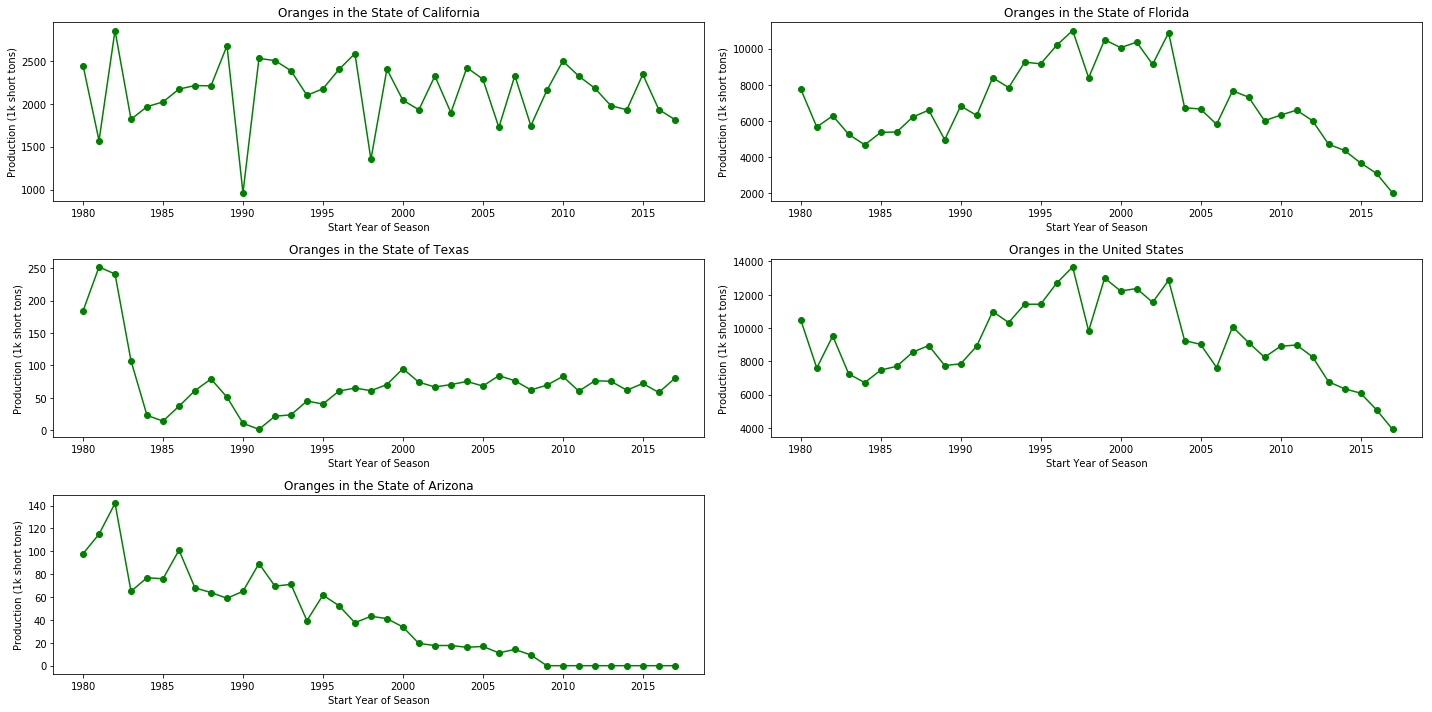

In [4]:
plot_time_series(cleaned_data_oranges, 'Oranges', YearbookPlotType.YIELD_PER_ACRE)
plot_time_series(cleaned_data_oranges, 'Oranges', YearbookPlotType.BEARING_ACREAGE)
plot_time_series(cleaned_data_oranges, 'Oranges', YearbookPlotType.PRODUCTION)

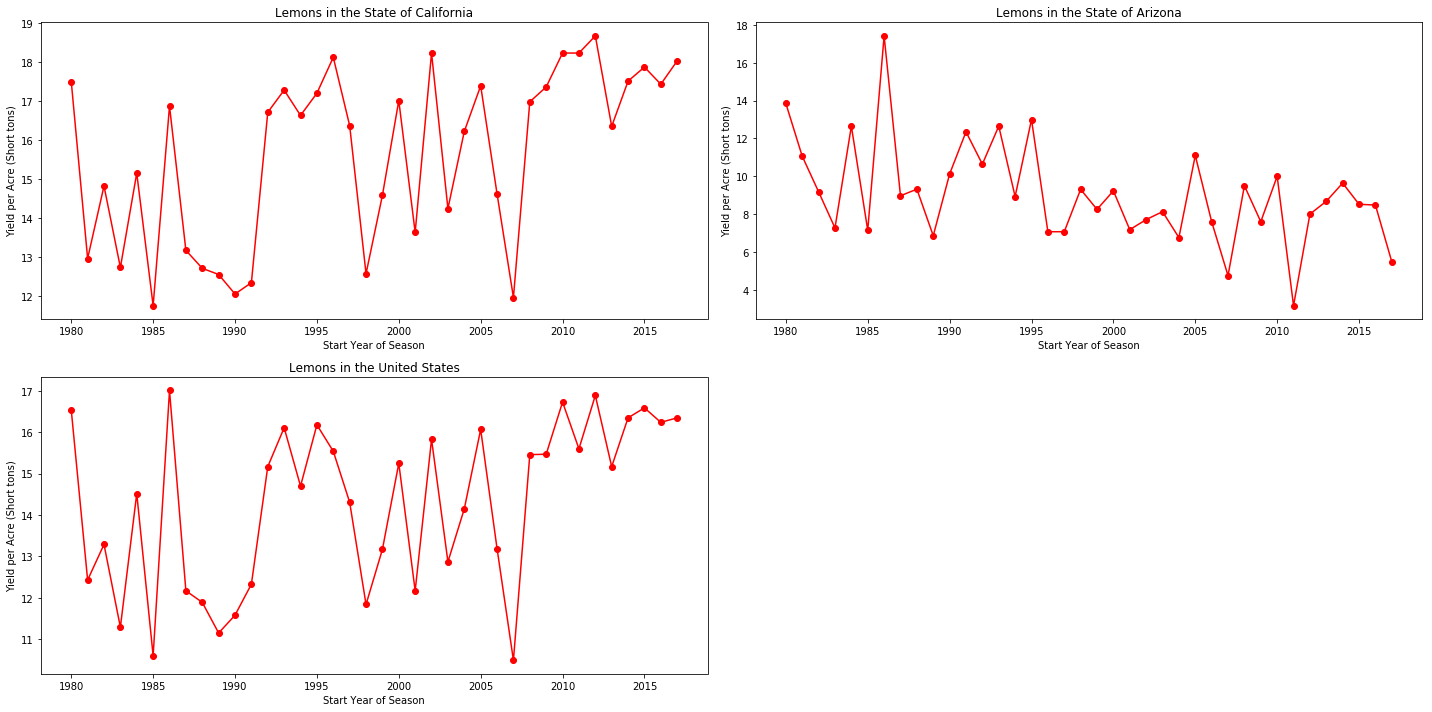

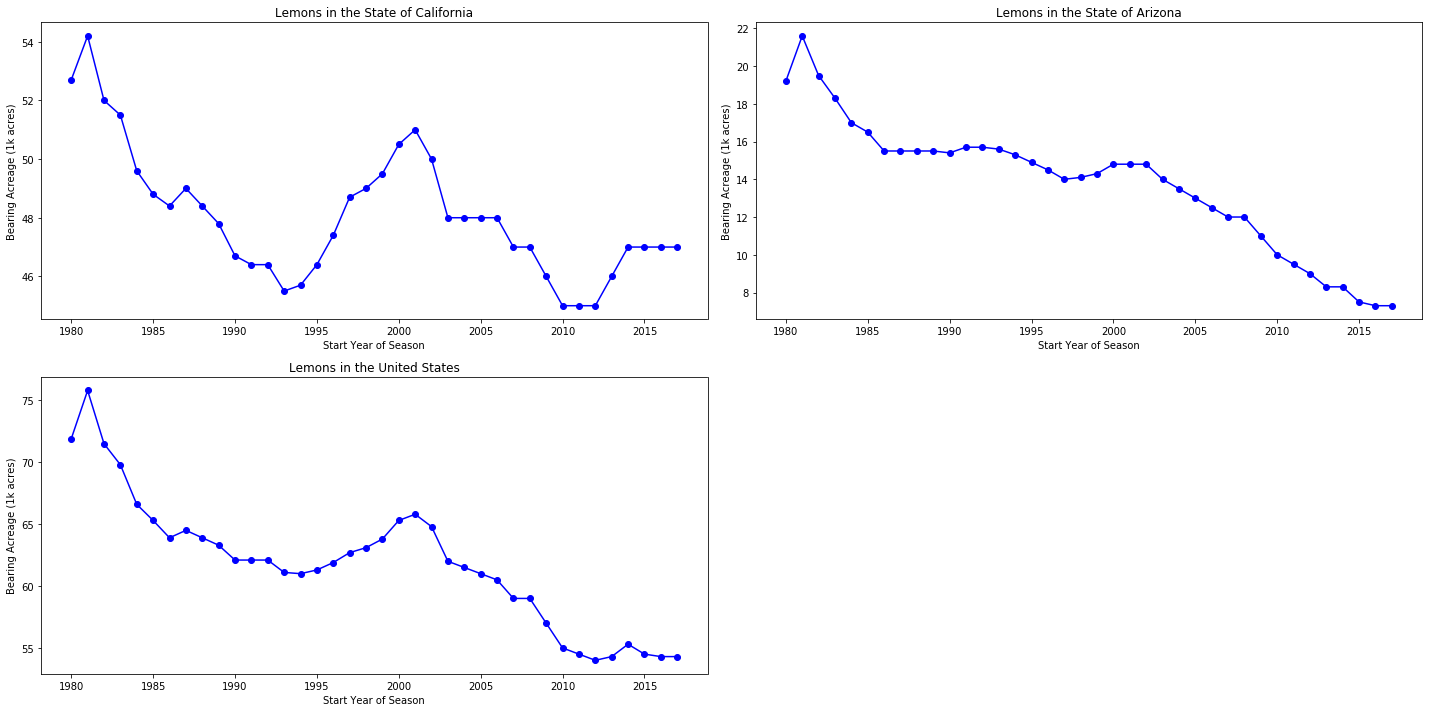

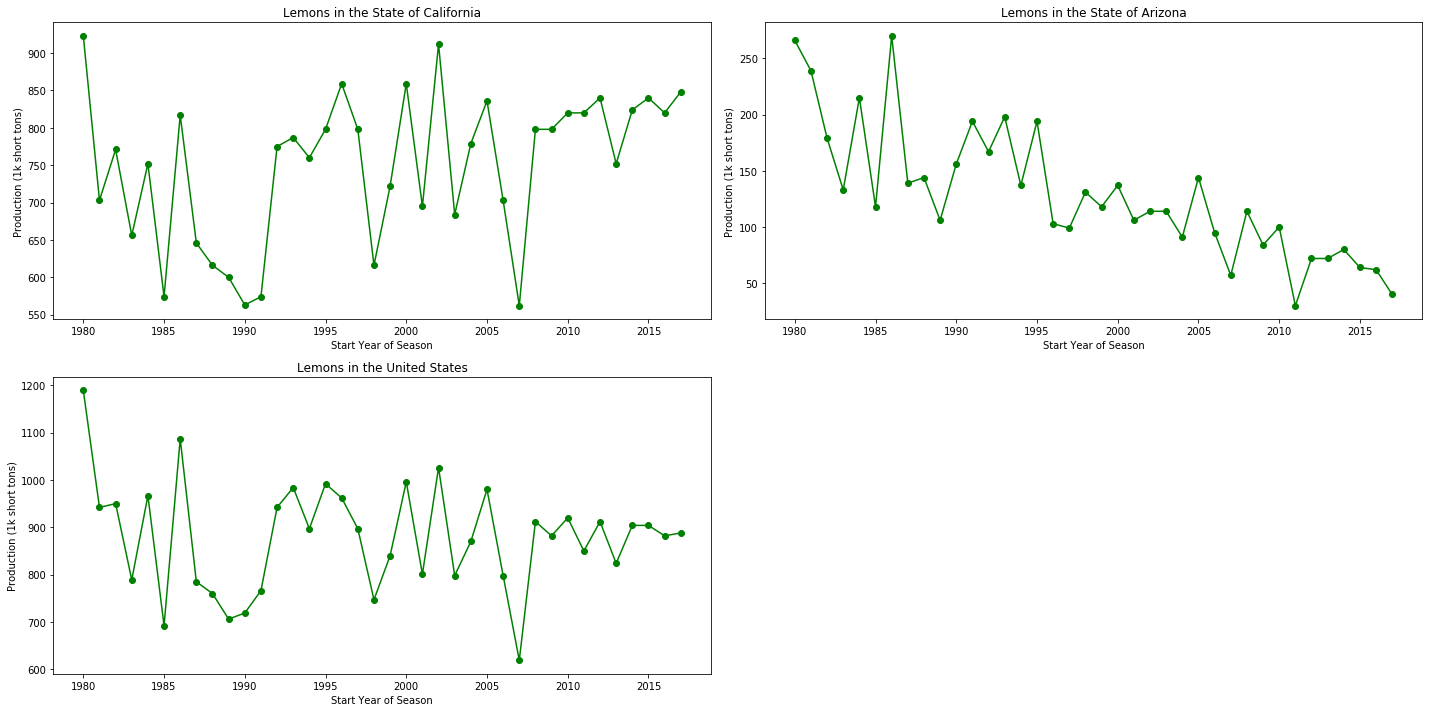

In [5]:
plot_time_series(cleaned_data_lemons, 'Lemons', YearbookPlotType.YIELD_PER_ACRE)
plot_time_series(cleaned_data_lemons, 'Lemons', YearbookPlotType.BEARING_ACREAGE)
plot_time_series(cleaned_data_lemons, 'Lemons', YearbookPlotType.PRODUCTION)

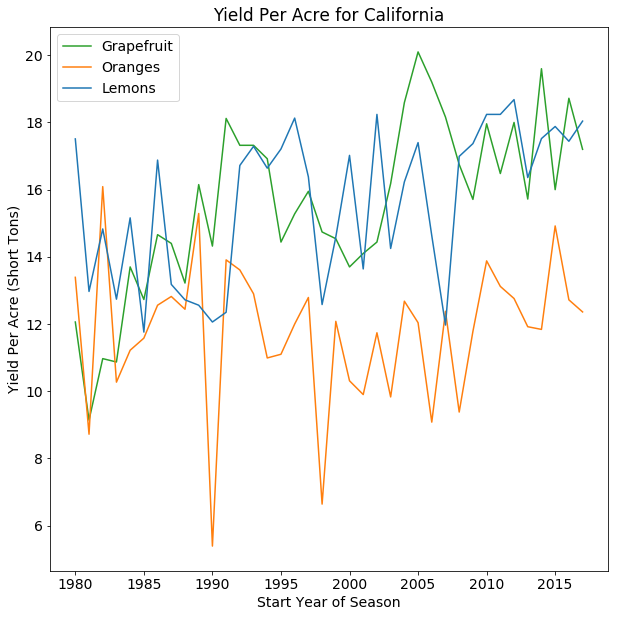

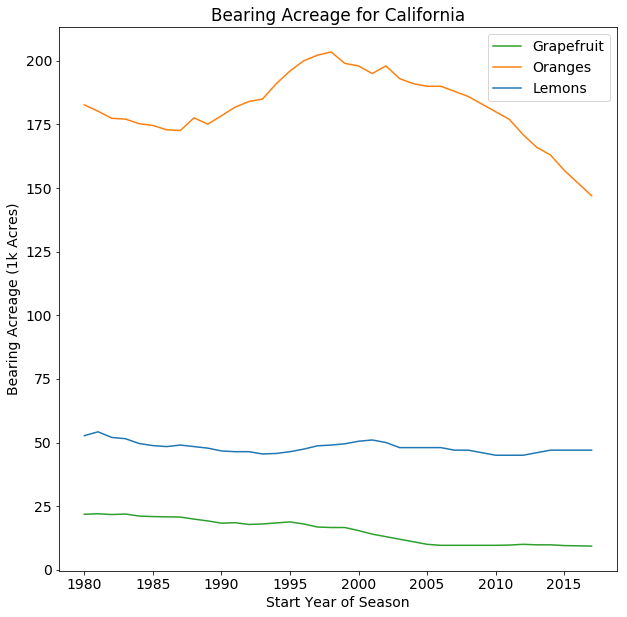

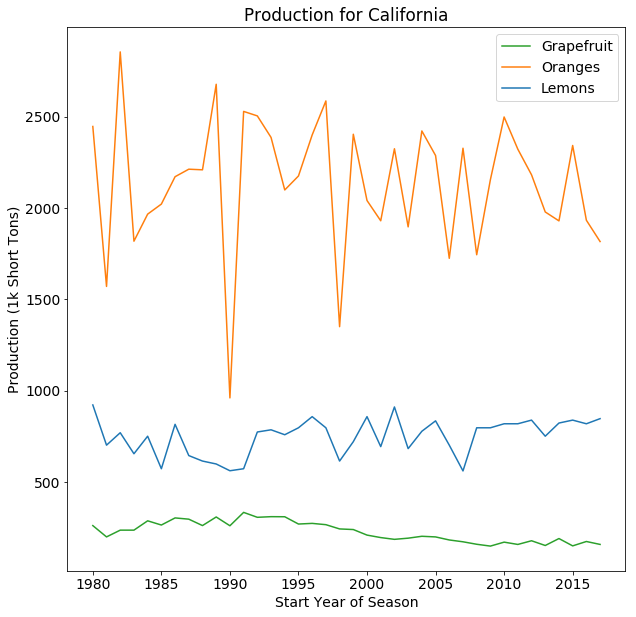

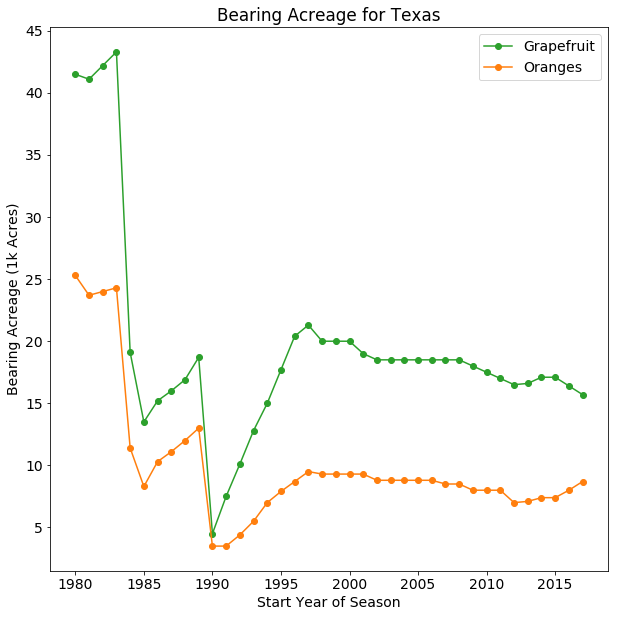

In [6]:
def plot_time_series_for_state(state, plot_type, fmt='-'):
    
    plt.rcParams['figure.figsize'] = (10, 10)
    plt.rcParams['font.size'] = 14.0
    plt.rcParams['axes.labelsize'] = 'medium'
    
    state_grapefruit = [row for row in cleaned_data_grapefruit if row[1] == state]
    state_oranges = [row for row in cleaned_data_oranges if row[1] == state]
    state_lemons = [row for row in cleaned_data_lemons if row[1] == state]
    
    colors = ['C0', 'C1', 'C2']
    
    years = [int(row[0][:5]) for row in state_grapefruit]
    
    if plot_type == YearbookPlotType.YIELD_PER_ACRE:
        title_string = 'Yield Per Acre for ' + state
        y_label = 'Yield Per Acre (Short Tons)'
        plt.plot(years, [row[3] for row in state_grapefruit], fmt, c='C2', label='Grapefruit')
        plt.plot(years, [row[3] for row in state_oranges], fmt, c='C1', label='Oranges')
        if state != 'Texas':
            plt.plot(years, [row[3] for row in state_lemons], fmt, c='C0', label='Lemons')
        plt.title(title_string)
        plt.xlabel('Start Year of Season')
        plt.ylabel(y_label)
        plt.legend()
        plt.show()
    elif plot_type == YearbookPlotType.BEARING_ACREAGE:
        title_string = 'Bearing Acreage for ' + state
        y_label = 'Bearing Acreage (1k Acres)'
        plt.plot(years, [row[2] for row in state_grapefruit], fmt, c='C2', label='Grapefruit')
        plt.plot(years, [row[2] for row in state_oranges], fmt, c='C1', label='Oranges')
        if state != 'Texas':
            plt.plot(years, [row[2] for row in state_lemons], fmt, c='C0', label='Lemons')
        plt.title(title_string)
        plt.xlabel('Start Year of Season')
        plt.ylabel(y_label)
        plt.legend()
        plt.show()
    else:
        title_string = 'Production for ' + state
        y_label = 'Production (1k Short Tons)'
        plt.plot(years, [row[2] * row[3] for row in state_grapefruit], fmt, c='C2', label='Grapefruit')
        plt.plot(years, [row[2] * row[3] for row in state_oranges], fmt, c='C1', label='Oranges')
        if state != 'Texas':
            plt.plot(years, [row[4] for row in state_lemons], fmt, c='C0', label='Lemons')
        plt.title(title_string)
        plt.xlabel('Start Year of Season')
        plt.ylabel(y_label)
        plt.legend()
        plt.show()
        
        
plot_time_series_for_state('California', YearbookPlotType.YIELD_PER_ACRE)
plot_time_series_for_state('California', YearbookPlotType.BEARING_ACREAGE)
plot_time_series_for_state('California', YearbookPlotType.PRODUCTION)

plot_time_series_for_state('Texas', YearbookPlotType.BEARING_ACREAGE, fmt='-o')

# Average Production of Citrus Crops by State

- Here we plot pie charts for each of the four states, showing the average production of each of the three major citrus crops (Lemons, Grapefruit, and Oranges) as a fraction of the total average production of each state.

- We see that of the four states highlighted by USDA as the major producers of citrus, only Arizona and California have production data for oranges, lemons, and grapefruit.

- In order to narrow the scope of our data analysis, we have decided to select only one of the four major citrus producing states to analyze more deeply, in trying to determine which extrinsic factors have contributed most significantly to the observed decline in citrus production over the past four decades.

- While both Arizona and California have historically produced enough of all three crops to warrant having the USDA report census information on them, in recent years, bearing acreage for both oranges and grapefruit have dropped to such a low level in the state of Arizona that the USDA is no longer those crops in its census reporting for Arizona.

- Therefore, we have decided to focus our analysis on citrus production in the state of California, because this state still produces enough of all three citrus crops to warrant having this production data reported by USDA.

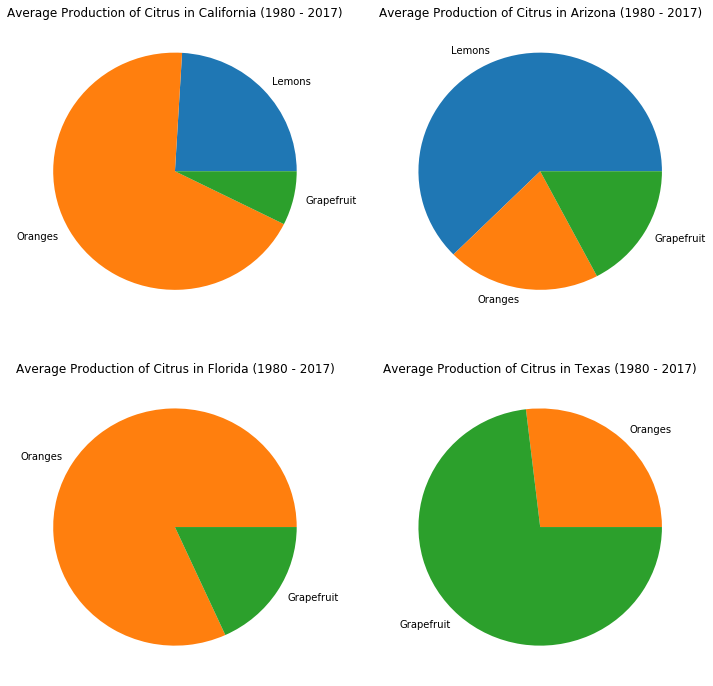

In [7]:
# Plot pie charts of average production for each of the major citrus crops, for each state

def average(items):
    
    if len(items) == 0:
        return len(items)
    
    return sum(items) / len(items)

states = ['California', 'Arizona', 'Florida', 'Texas']

curr_subplot = 1

plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 10

for state in states:

    lemons_data_state = [row for row in cleaned_data_lemons if row[1] == state]
    oranges_data_state = [row for row in cleaned_data_oranges if row[1] == state]
    grapefruit_data_state = [row for row in cleaned_data_grapefruit if row[1] == state]

    lemons_production_state = [row[4] for row in lemons_data_state]
    oranges_production_state = [row[2] * row[3] for row in oranges_data_state]
    grapefruit_production_state = [row[2] * row[3] for row in grapefruit_data_state]

    avg_lemons_state = average(lemons_production_state)
    avg_oranges_state = average(oranges_production_state)
    avg_grapefruit_state = average(grapefruit_production_state)

    xs = np.array([avg_lemons_state, avg_oranges_state, avg_grapefruit_state])
    labels = np.array(['Lemons', 'Oranges', 'Grapefruit'])
    colors = np.array(['C0', 'C1', 'C2'])
    
    mask = []
    for i in range(len(xs)):
        if int(xs[i]) == 0:
            mask.append(False)
        else:
            mask.append(True)
    xs = xs[mask]
    labels = labels[mask]
    colors = colors[mask]

    plt.subplot(2, 2, curr_subplot)
    plt.pie(xs, labels=labels, colors=colors)
    curr_subplot += 1
    plt.title('Average Production of Citrus in ' + state + ' (1980 - 2017)')
    
plt.show()

In [8]:
mask = [True, False, True]
nums = np.array([1, 2, 3])
nums = nums[mask]
print(nums)

[1 3]


# Pie Charts of Production

Here we plot pie charts showing the contribution of production by state for each of the three citrus crops in the 2017/18 season. We see that California is a major contributor to the overall production of all three citrus crops in the 2017/18 season.

Production Values by State
[('California', 848.0), ('Arizona', 40.0)]


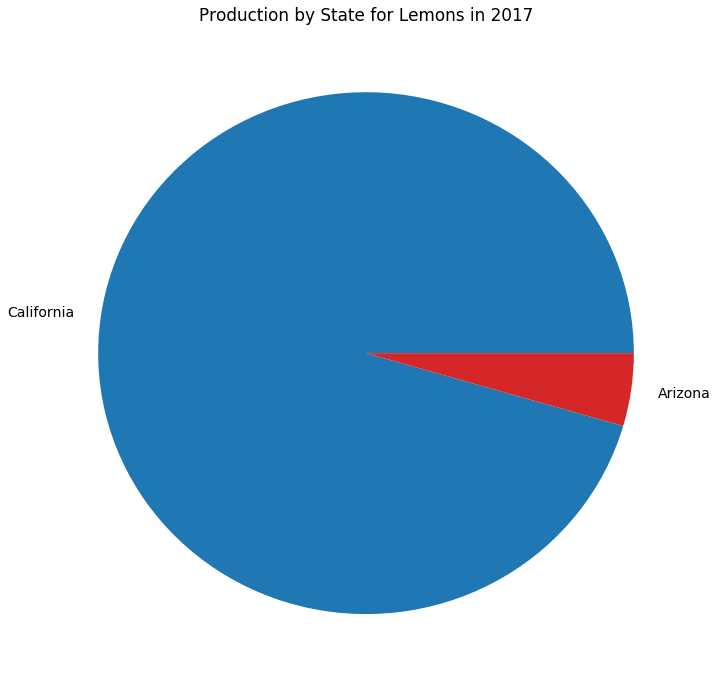

Production Values by State
[('Florida', 2018.844), ('California', 1816.9199999999998), ('Texas', 79.86599999999999)]


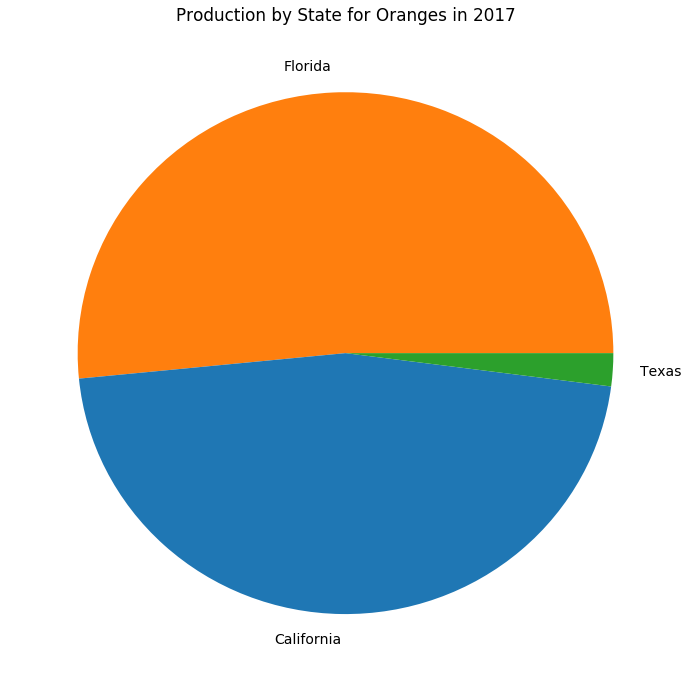

Production Values by State
[('Florida', 164.794), ('California', 159.96), ('Texas', 192.168)]


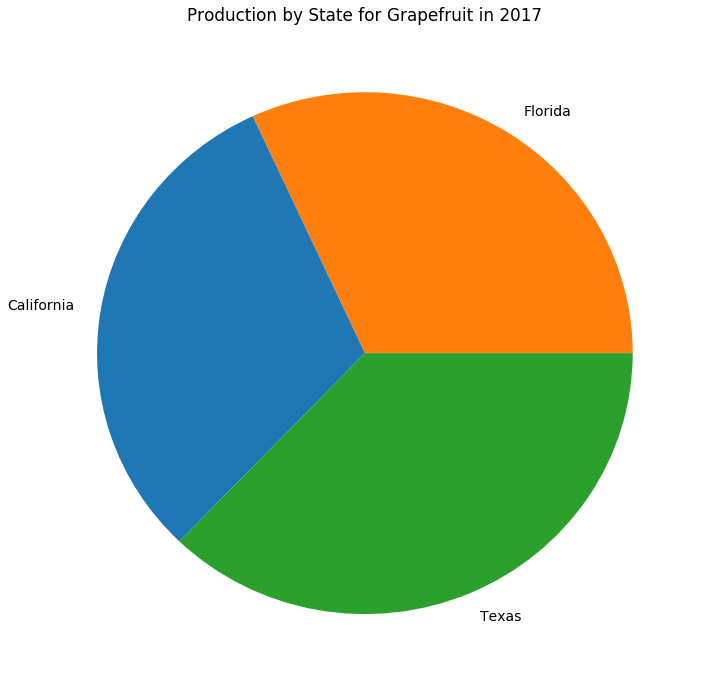

In [9]:
# define a helper function for getting the boolean masks for the pie charts
def get_boolean_mask(xs, labels):
    mask = []
    for label in labels:
        if len([(state, _) for (state, _) in xs if state == label]) == 0:
            mask.append(False)
        else:
            mask.append(True)
    return mask


# plot a pie chart of production percent production contributed by each state, for each crop in 2018

plt.rcParams['font.size'] = 14.0

color_dict = {
    'California': 'C0',
    'Florida': 'C1',
    'Texas': 'C2',
    'Arizona': 'C3',
}

labels = np.array(['Florida', 'California', 'Texas', 'Arizona'])
colors = np.array([color_dict[label] for label in labels])

lemons_production_2017 = [row for row in cleaned_data_lemons if row[0][:5] == ' 2017']
xs = [(row[1], row[4]) for row in lemons_production_2017 if row[1] != 'United States' and row[4] != 0]
print('Production Values by State')
print(xs)
mask = get_boolean_mask(xs, labels)
xs = [x for (_, x) in xs]
plt.pie(xs, labels=labels[mask], colors=colors[mask])
plt.title('Production by State for Lemons in 2017')
plt.show()


oranges_production_2017 = [row for row in cleaned_data_oranges if row[0][:5] == ' 2017']
xs = [(row[1], row[2] * row[3]) for row in oranges_production_2017 if row[1] != 'United States' and row[2] * row[3] != 0]
print('Production Values by State')
print(xs)
mask = get_boolean_mask(xs, labels)
xs = [x for (_, x) in xs]
plt.pie(xs, labels=labels[mask], colors=colors[mask])
plt.title('Production by State for Oranges in 2017')
plt.show()

grapefruit_production_2017 = [row for row in cleaned_data_grapefruit if row[0][:5] == ' 2017']
xs = [(row[1], row[2] * row[3]) for row in grapefruit_production_2017 if row[1] != 'United States' and row[2] * row[3] != 0]
print('Production Values by State')
print(xs)
mask = get_boolean_mask(xs, labels)
xs = [x for (_, x) in xs]
plt.pie(xs, labels=labels[mask], colors=colors[mask])
plt.title('Production by State for Grapefruit in 2017')
plt.show()

    

# Aggregating Weather Station Readings for the State of California
According to [an article](https://apps1.cdfa.ca.gov/FertilizerResearch/docs/Citrus_Production_CA.pdf) released by the California Department of Food and Agriculture, and dated June 2016, the top citrus producing counties in the state of California are:
- Fresno
- Kern
- Tulare
- Ventura
- Riverside

Here we aggregate temperature and humidity readings, gathered from weather stations in each the five counties highlighted above, using SQL commands.
The raw data is comprised of hourly sensor readings of Dry Bulb Temperature, and Relative Humidity, as well as numerous other weather metrics.
We aggregate the data into daily/monthly/yearly averages, maximums, and minimums.
We also generate a few other yearly metrics, including the following:

- Temperature range (max - min)
- Number of days with temperatures 10 degrees above the yearly average, by year
- Number of days with temperatures 10 degrees below the yearly average, by year
- Number of days with minimum temperatures below 32 degrees, by year
- Number of days with minimum temperatures within 3 degrees of the monthly minimum, in months with extreme lows, by year
- Number of days with temperatures 7 degrees above the monthly average, by year
- Number of days with temperatures 7 degrees below the monthly average, by year
- Number of days with relative humidity 15% or more above the monthly average, by year
- Number of days with relative humidity 25% or more above the yearly average


In [10]:
import sqlite3
from sqlite3 import Error

# fetch the weather station readings gathered from the ncdc by county
counties = ['Fresno', 'Ventura', 'Kern', 'Riverside', 'Tulare']
selections_average_daily = 'STATION_NAME, date(DATE) as DT, AVG(HOURLYDRYBULBTEMPF), AVG(HOURLYRelativeHumidity)'
group_by_average_daily = ' GROUP BY DT'
selections_average_yearly = 'STATION_NAME, substr(DATE, 1, 4) as YEAR, AVG(HOURLYDRYBULBTEMPF), AVG(HOURLYRelativeHumidity)'
group_by_average_yearly = ' GROUP BY YEAR'
queries = [
    (selections_average_daily, group_by_average_daily), 
    (selections_average_yearly, group_by_average_yearly),
]
data_collections = []

for county in counties:
    county_fetch = [county]
    conn = sqlite3.connect('./ncdc/lcd/california/' + county + '/' + county.lower() + '.db')
    cursor = conn.cursor()
    cursor.execute('SELECT name from sqlite_master WHERE type = "table"')
    tables = cursor.fetchall()
    for (table, ) in tables:
        for select, group in queries:
            cursor.execute('SELECT ' + select + ' FROM ' + table + group)
            county_fetch.append(cursor.fetchall())
    data_collections.append(county_fetch)
    
#conn = sqlite3.connect('./ncdc/lcd/california/Fresno/fresno.db')

#cursor = conn.cursor()

#cursor.execute('SELECT ' + selections + 'FROM fresno00_09 GROUP BY date(DATE)')
#data = cursor.fetchall()
print(len(data_collections))

fresno_data = data_collections[0]
ventura_data = data_collections[1]
kern_data = data_collections[2]
riverside_data = data_collections[3]
tulare_data = data_collections[4]

conn.close()

5


In [11]:
# aggregate yearly, monthly, and daily average temperature and humidity readings for the state of california
conn = sqlite3.connect('./ncdc/lcd/california/california.db')
cursor = conn.cursor()
cursor.execute('SELECT substr(DATE, 1, 4) as YEAR, AVG(CAST(HOURLYDRYBULBTEMPF as decimal)), \
AVG(CAST(HOURLYRelativeHumidity as decimal)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY YEAR')
california_yearly_averages = cursor.fetchall()

cursor.execute('SELECT date(DATE) as DT, AVG(CAST(HOURLYDRYBULBTEMPF as decimal)), \
AVG(CAST(HOURLYRelativeHumidity as decimal)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY DT')
california_daily_averages = cursor.fetchall()

cursor.execute('SELECT substr(DATE, 1, 7) as MONTH, AVG(CAST(HOURLYDRYBULBTEMPF as decimal)), \
AVG(CAST(HOURLYRelativeHumidity as decimal)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY MONTH')
california_monthly_averages = cursor.fetchall()

cursor.close()
print(california_yearly_averages)

[('2000', 62.37925576814857, 65.337120146314), ('2001', 63.04289176941722, 64.42118944743036), ('2002', 62.5106013208203, 62.918143899895725), ('2003', 63.99135283944517, 64.95768185508065), ('2004', 63.18294237194723, 61.40622093624057), ('2005', 63.15528465324701, 64.59716317061553), ('2006', 62.620637370010066, 60.94749412948675), ('2007', 61.581198428025445, 57.75716774481073), ('2008', 62.33091639389158, 60.744904213560076), ('2009', 61.83883459339849, 62.164919259239745), ('2010', 61.20380897058213, 66.41962297553351), ('2011', 60.806963904435825, 63.793811828024914), ('2012', 63.161073658238735, 60.53043651634288), ('2013', 64.39047867878604, 52.06764208412976), ('2014', 66.28551077496891, 54.66566514711977), ('2015', 65.55001862891207, 57.40092080051097), ('2016', 64.39263922206301, 60.473363064092865), ('2017', 64.56373150720331, 61.70871826345371), ('2018', 66.0563915431495, 57.87598751034535)]


In [12]:
# aggregate yearly, monthly, and daily maximum temperature and humidity readings for the state of california
conn = sqlite3.connect('./ncdc/lcd/california/california.db')
cursor = conn.cursor()
cursor.execute('SELECT substr(DATE, 1, 4) as YEAR, MAX(CAST(HOURLYDRYBULBTEMPF as integer)), \
MAX(CAST(HOURLYRelativeHumidity as integer)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY YEAR')
california_yearly_max = cursor.fetchall()

cursor.execute('SELECT date(DATE) as DT, MAX(CAST(HOURLYDRYBULBTEMPF as integer)), \
MAX(CAST(HOURLYRelativeHumidity as integer)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY DT')
california_daily_max = cursor.fetchall()

cursor.execute('SELECT substr(DATE, 1, 7) as MONTH, MAX(CAST(HOURLYDRYBULBTEMPF as integer)), \
MAX(CAST(HOURLYRelativeHumidity as integer)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY MONTH')
california_monthly_max = cursor.fetchall()

cursor.close()
print(california_yearly_max)

[('2000', 108, 100), ('2001', 110, 100), ('2002', 108, 100), ('2003', 108, 100), ('2004', 106, 100), ('2005', 108, 100), ('2006', 113, 100), ('2007', 110, 100), ('2008', 112, 107), ('2009', 110, 100), ('2010', 113, 100), ('2011', 107, 100), ('2012', 110, 102), ('2013', 110, 100), ('2014', 109, 100), ('2015', 109, 100), ('2016', 113, 100), ('2017', 111, 100), ('2018', 117, 100)]


In [13]:
# aggregate yearly, monthly, and daily minimum temperature and humidity readings for the state of california
conn = sqlite3.connect('./ncdc/lcd/california/california.db')
cursor = conn.cursor()
cursor.execute('SELECT substr(DATE, 1, 4) as YEAR, MIN(CAST(HOURLYDRYBULBTEMPF as integer)), \
MIN(CAST(HOURLYRelativeHumidity as integer)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY YEAR')
california_yearly_min = cursor.fetchall()

cursor.execute('SELECT date(DATE) as DT, MIN(CAST(HOURLYDRYBULBTEMPF as integer)), \
MIN(CAST(HOURLYRelativeHumidity as integer))FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY DT')
california_daily_min = cursor.fetchall()

cursor.execute('SELECT substr(DATE, 1, 7) as MONTH, MIN(CAST(HOURLYDRYBULBTEMPF as integer)), \
MIN(CAST(HOURLYRelativeHumidity as integer)) FROM \
(SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM fresno \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM kern \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM tulare \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_march \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM riverside_mun \
UNION ALL SELECT DATE, HOURLYDRYBULBTEMPF, HOURLYRelativeHumidity FROM ventura) \
GROUP BY MONTH')
california_monthly_min = cursor.fetchall()

cursor.close()

In [14]:
print(california_yearly_min)
print(california_monthly_min[:24])


[('2000', 27, 6), ('2001', 30, 5), ('2002', 28, 7), ('2003', 30, 8), ('2004', 26, 6), ('2005', 30, 5), ('2006', 27, 3), ('2007', 19, 3), ('2008', 25, 2), ('2009', 25, 3), ('2010', 23, 4), ('2011', 23, 2), ('2012', 25, 2), ('2013', 22, 2), ('2014', 27, 2), ('2015', 23, 4), ('2016', 18, 3), ('2017', 7, 2), ('2018', 20, 3)]
[('2000-01', 27, 16), ('2000-02', 35, 12), ('2000-03', 37, 14), ('2000-04', 41, 11), ('2000-05', 43, 12), ('2000-06', 48, 13), ('2000-07', 52, 11), ('2000-08', 54, 12), ('2000-09', 53, 13), ('2000-10', 44, 12), ('2000-11', 31, 13), ('2000-12', 29, 6), ('2001-01', 30, 5), ('2001-02', 30, 13), ('2001-03', 38, 27), ('2001-04', 36, 17), ('2001-05', 45, 9), ('2001-06', 50, 8), ('2001-07', 50, 12), ('2001-08', 54, 13), ('2001-09', 48, 13), ('2001-10', 48, 17), ('2001-11', 34, 19), ('2001-12', 32, 11)]


In [15]:
days_below_yearly_average_temp = []
days_above_yearly_average_temp = []
days_below_monthly_average_temp = []
days_above_monthly_average_temp = []
days_min_temp_below_32 = []
days_min_temp_close_monthly_min = []

In [16]:
# days in which the temperature was 10 degrees or more below the yearly average, and 10 degrees or more above the yearly average
for year, ytemp, yhumidity in california_yearly_averages:
    current_year = [year]
    
    days_below = [(date, temp, humidity) for (date, temp, humidity) in california_daily_averages if date[:4] == year and temp < ytemp - 10]
    days_below_yearly_average_temp.append(current_year + [len(days_below)])
    
    days_above = [(date, temp, humidity) for (date, temp, humidity) in california_daily_averages if date[:4] == year and temp > ytemp + 10]
    days_above_yearly_average_temp.append(current_year + [len(days_above)])

print(days_above_yearly_average_temp)
print(days_below_yearly_average_temp)

monthly_lows_dict = dict([(year, 0) for (year, temp, humidity) in california_yearly_averages])
monthly_highs_dict = dict([(year, 0) for (year, temp, humidity) in california_yearly_averages])

# days in which the temperature was 7 degrees or more below the monthly average, and 7 degrees or more above the monthly average
for month, mtemp, mhumidity in california_monthly_averages:
    days_below = [(date, temp, humidity) for (date, temp, humidity) in california_daily_averages if date[:7] == month and temp < mtemp - 7]
    days_above = [(date, temp, humidity) for (date, temp, humidity) in california_daily_averages if date[:7] == month and temp > mtemp + 7]
    
    monthly_lows_dict[month[:4]] += len(days_below)
    monthly_highs_dict[month[:4]] += len(days_above)

print(monthly_lows_dict)
print(monthly_highs_dict)

# number of days in which the min temperature was within 3 degrees of the monthly low, with a monthly low < 32, by year
monthly_extremes_dict = dict([(year, 0) for (year, _, _) in california_yearly_averages])

for month, mtemp, mhumidity in california_monthly_min:
    
    days_within_range = [(date, temp, _) for (date, temp, _) in california_daily_min if date[:7] == month and temp < mtemp + 3 and mtemp < 32]
    monthly_extremes_dict[month[:4]] += len(days_within_range)

print(monthly_extremes_dict)

# days in which the average humidity was 15% or more above the monthly average, grouped by year
monthly_humidity_highs_dict = dict([(year, 0) for (year, _, _) in california_yearly_averages])

for month, _, mhumidity in california_monthly_averages:
    days_above = [(date, _, humidity) for (date, _, humidity) in california_daily_averages if date[:7] == month and humidity >= mhumidity + 15]
    monthly_humidity_highs_dict[month[:4]] += len(days_above)

print(monthly_humidity_highs_dict)

# days in which the average humidity was 25% or more above the yearly average, grouped by year
yearly_humidity_highs_dict = dict([(year, 0) for (year, _, _) in california_yearly_averages])

for year, _, yhumidity in california_yearly_averages:
    days_above = [(date, _, humidity) for (date, _, humidity) in california_daily_averages if date[:4] == year and humidity >= yhumidity + 25]
    yearly_humidity_highs_dict[year] += len(days_above)

print(yearly_humidity_highs_dict)
    
# days in which the minimum temperature was below 32 degrees fahrenheit
for year, ytemp, yhumidity in california_yearly_averages:
    current_year = [year]
    
    days_below = [(date, temp, humidity) for (date, temp, humidity) in california_daily_min if date[:4] == year and temp < 32]
    days_min_temp_below_32.append(current_year + [len(days_below)])
print(days_min_temp_below_32)


[['2000', 102], ['2001', 107], ['2002', 105], ['2003', 105], ['2004', 98], ['2005', 76], ['2006', 100], ['2007', 95], ['2008', 109], ['2009', 101], ['2010', 83], ['2011', 103], ['2012', 102], ['2013', 92], ['2014', 96], ['2015', 101], ['2016', 91], ['2017', 92], ['2018', 70]]
[['2000', 85], ['2001', 98], ['2002', 71], ['2003', 98], ['2004', 94], ['2005', 58], ['2006', 92], ['2007', 84], ['2008', 89], ['2009', 78], ['2010', 70], ['2011', 92], ['2012', 87], ['2013', 77], ['2014', 73], ['2015', 94], ['2016', 69], ['2017', 76], ['2018', 59]]
{'2000': 21, '2001': 15, '2002': 20, '2003': 17, '2004': 27, '2005': 9, '2006': 22, '2007': 23, '2008': 13, '2009': 14, '2010': 21, '2011': 16, '2012': 21, '2013': 22, '2014': 24, '2015': 26, '2016': 21, '2017': 23, '2018': 15}
{'2000': 28, '2001': 24, '2002': 21, '2003': 16, '2004': 21, '2005': 9, '2006': 25, '2007': 21, '2008': 22, '2009': 27, '2010': 31, '2011': 19, '2012': 17, '2013': 24, '2014': 19, '2015': 24, '2016': 21, '2017': 25, '2018': 10}


# Generating Pandas Dataframes with Combined Agricultural and Weather Data, By Year
Now that we have generated the aggregate weather metrics for the state of California, we are ready to combine the citrus agricultural data and that weather data into a single Pandas Dataframe. Here, we generate separate such pandas dataframes for each of the citrus crops analyzed in this study: Lemons, Grapefruits, and Oranges.
- First we pull out all of the citrus data for the state of California, and then we group it with the weather data by year
- We pull a list of each of the summary statistics generated from the weather data, to be added to columns in our data frames
- Having the data aggregated into Dataframes will make plotting and analyzing the relationships between the agricultural and weather data much simpler.


In [17]:
california_data_grapefruit = [
    (date[1:][:4], ypa, ba, ypa * ba) 
    for [date, state, ba, ypa] in cleaned_data_grapefruit 
    if state == 'California' and int(date[1:][:4]) >= 2000
]
california_data_oranges = [
    (date[1:][:4], ypa, ba, ypa * ba) 
    for [date, state, ba, ypa] in cleaned_data_oranges 
    if state == 'California' and int(date[1:][:4]) >= 2000
]
california_data_lemons = [
    (date[1:][:4], ypa, ba, prod) 
    for [date, state, ba, ypa, prod] in cleaned_data_lemons 
    if state == 'California' and int(date[1:][:4]) >= 2000
]
print(california_data_lemons)

[('2000', 17.02, 50.5, 859.0), ('2001', 13.64, 51.0, 695.0), ('2002', 18.24, 50.0, 912.0), ('2003', 14.25, 48.0, 684.0), ('2004', 16.23, 48.0, 779.0), ('2005', 17.4, 48.0, 836.0), ('2006', 14.63, 48.0, 703.0), ('2007', 11.97, 47.0, 562.0), ('2008', 16.99, 47.0, 798.0), ('2009', 17.37, 46.0, 798.0), ('2010', 18.24, 45.0, 820.0), ('2011', 18.24, 45.0, 820.0), ('2012', 18.68, 45.0, 840.0), ('2013', 16.36, 46.0, 752.0), ('2014', 17.52, 47.0, 824.0), ('2015', 17.88, 47.0, 840.0), ('2016', 17.44, 47.0, 820.0), ('2017', 18.04, 47.0, 848.0)]


In [18]:
import pandas as pd
# get data into lists so that they can be fed to the columns of a DataFrame via a dictionary
years = [int(year) for (year, _, _, _) in california_data_grapefruit]
ypa_grapefruit = [ypa for (_, ypa, _, _) in california_data_grapefruit]
ba_grapefruit = [ba for (_, _, ba, _) in california_data_grapefruit]
prod_grapefruit = [prod for (_, _, _, prod) in california_data_grapefruit]

ypa_oranges = [ypa for (_, ypa, _, _) in california_data_oranges]
ba_oranges = [ba for (_, _, ba, _) in california_data_oranges]
prod_oranges = [prod for (_, _, _, prod) in california_data_oranges]

ypa_lemons = [ypa for (_, ypa, _, _) in california_data_lemons]
ba_lemons = [ba for (_, _, ba, _) in california_data_lemons]
prod_lemons = [prod for (_, _, _, prod) in california_data_lemons]

yearly_average_temp = [temp for (year, temp, _) in california_yearly_averages if year != '2018']
yearly_min_temp = [temp for (year, temp, _) in california_yearly_min if year != '2018']
yearly_max_temp = [temp for (year, temp, _) in california_yearly_max if year != '2018']
yearly_temp_range = [
    max_temp - min_temp
    for (max_year, max_temp, _) in california_yearly_max
    for (min_year, min_temp, _) in california_yearly_min
    if max_year == min_year and max_year != '2018'
]
yearly_days_temp_below = [
    count for [year, count] in days_below_yearly_average_temp if year != '2018'
]
yearly_days_temp_above = [
    count for [year, count] in days_above_yearly_average_temp if year != '2018'
]
yearly_days_temp_below_monthly = [
    count for year, count in monthly_lows_dict.items() if year != '2018'
]
yearly_days_temp_above_monthly = [
    count for year, count in monthly_highs_dict.items() if year != '2018'
]
yearly_days_temp_extreme_monthly = [
    count for year, count in monthly_extremes_dict.items() if year != '2018'
]
yearly_days_temp_below_32 = [
    count for [year, count] in days_min_temp_below_32 if year != '2018'
]
yearly_days_humidity_above_monthly = [
    count for year, count in monthly_humidity_highs_dict.items() if year != '2018'
]
yearly_days_humidity_above_yearly = [
    count for year, count in yearly_humidity_highs_dict.items() if year != '2018'
]

grapefruit_data_dict = {
    'Year': years,
    'Yield Per Acre (Short Tons)': ypa_grapefruit,
    'Bearing Acreage (1k Acres)': ba_grapefruit,
    'Production (1k Short Tons)': prod_grapefruit,
    'Average Temp (F)': yearly_average_temp,
    'Min Temp (F)': yearly_min_temp,
    'Max Temp (F)': yearly_max_temp,
    'Temp Range (F)': yearly_temp_range,
    'Days Below Average Temp': yearly_days_temp_below,
    'Days Above Average Temp': yearly_days_temp_above,
    'Days Below Monthly Average Temp': yearly_days_temp_below_monthly,
    'Days Above Monthly Average Temp': yearly_days_temp_above_monthly,
    'Days With Temp Close to Monthly Extreme': yearly_days_temp_extreme_monthly,
    'Days with Temp Below Freezing': yearly_days_temp_below_32,
    'Days Above Monthly Average Humidity': yearly_days_humidity_above_monthly,
    'Days Above Average Humidity': yearly_days_humidity_above_yearly
}

grapefruit_df = pd.DataFrame.from_dict(grapefruit_data_dict)

oranges_data_dict = {
    'Year': years,
    'Yield Per Acre (Short Tons)': ypa_oranges,
    'Bearing Acreage (1k Acres)': ba_oranges,
    'Production (1k Short Tons)': prod_oranges,
    'Average Temp (F)': yearly_average_temp,
    'Min Temp (F)': yearly_min_temp,
    'Max Temp (F)': yearly_max_temp,
    'Temp Range (F)': yearly_temp_range,
    'Days Below Average Temp': yearly_days_temp_below,
    'Days Above Average Temp': yearly_days_temp_above,
    'Days Below Monthly Average Temp': yearly_days_temp_below_monthly,
    'Days Above Monthly Average Temp': yearly_days_temp_above_monthly,
    'Days With Temp Close to Monthly Extreme': yearly_days_temp_extreme_monthly,
    'Days with Temp Below Freezing': yearly_days_temp_below_32,
    'Days Above Monthly Average Humidity': yearly_days_humidity_above_monthly,
    'Days Above Average Humidity': yearly_days_humidity_above_yearly
}

oranges_df = pd.DataFrame.from_dict(oranges_data_dict)

lemons_data_dict = {
    'Year': years,
    'Yield Per Acre (Short Tons)': ypa_lemons,
    'Bearing Acreage (1k Acres)': ba_lemons,
    'Production (1k Short Tons)': prod_lemons,
    'Average Temp (F)': yearly_average_temp,
    'Min Temp (F)': yearly_min_temp,
    'Max Temp (F)': yearly_max_temp,
    'Temp Range (F)': yearly_temp_range,
    'Days Below Average Temp': yearly_days_temp_below,
    'Days Above Average Temp': yearly_days_temp_above,
    'Days Below Monthly Average Temp': yearly_days_temp_below_monthly,
    'Days Above Monthly Average Temp': yearly_days_temp_above_monthly,
    'Days With Temp Close to Monthly Extreme': yearly_days_temp_extreme_monthly,
    'Days with Temp Below Freezing': yearly_days_temp_below_32,
    'Days Above Monthly Average Humidity': yearly_days_humidity_above_monthly,
    'Days Above Average Humidity': yearly_days_humidity_above_yearly
}

lemons_df = pd.DataFrame.from_dict(lemons_data_dict)
lemons_df

,Year,Yield Per Acre (Short Tons),Bearing Acreage (1k Acres),Production (1k Short Tons),Average Temp (F),Min Temp (F),Max Temp (F),Temp Range (F),Days Below Average Temp,Days Above Average Temp,Days Below Monthly Average Temp,Days Above Monthly Average Temp,Days With Temp Close to Monthly Extreme,Days with Temp Below Freezing,Days Above Monthly Average Humidity,Days Above Average Humidity
0,2000,17.02,50.5,859.0,62.379256,27,108,81,85,102,21,28,11,9,11,6
1,2001,13.64,51.0,695.0,63.042892,30,110,80,98,107,15,24,11,6,3,9
2,2002,18.24,50.0,912.0,62.510601,28,108,80,71,105,20,21,11,11,11,16
3,2003,14.25,48.0,684.0,63.991353,30,108,78,98,105,17,16,3,2,8,13
4,2004,16.23,48.0,779.0,63.182942,26,106,80,94,98,27,21,10,11,6,19
5,2005,17.40,48.0,836.0,63.155285,30,108,78,58,76,9,9,5,3,10,5
6,2006,14.63,48.0,703.0,62.620637,27,113,86,92,100,22,25,25,30,10,2
7,2007,11.97,47.0,562.0,61.581198,19,110,91,84,95,23,21,15,41,20,7
8,2008,16.99,47.0,798.0,62.330916,25,112,87,89,109,13,22,13,27,12,20
9,2009,17.37,46.0,798.0,61.838835,25,110,85,78,101,14,27,22,32,21,9


# Analyzing the Effects of Temperature and Humidity Trends on Citrus Crop Yields in California

- Now that the yearly agricultural and weather data have been grouped into data frames, we are ready to analyze and try to elucidate any correlations/causal relationships between trends in temperature and humidity, and agricultural yields in the three citrus crops.
- Because Citrus crops in general are susceptible to damage by extremely cold temperatures, we would expect to see that years with lower extremes of temperature to experience lower yield per acre.
- Sense temperature/humidity regimes are more likely to put stress on existing citrus trees, as opposed to completely wiping them out and reducing bearing acreage, we would expect the decline in production reflected more so in the yield per acre than in the bearing acreage, or production which combines these two metrics.
- We start by generating pairwise pearson correlation statistics between the crop yield metrics, and the weather metrics, to try and highlight how strongly different weather metrics are linearly correlated with the crop trends.
- We also generate pairwise covariance coefficients to 

In [19]:
#grapefruit_df.plot.scatter(x='Min Temp (F)', y='Yield Per Acre (Short Tons)', s=50, title='Yearly Min Temp vs. Yield Per Acre in Grapefruits')
print('Correlation Matrix')
print(grapefruit_df.corr()[['Yield Per Acre (Short Tons)', 'Bearing Acreage (1k Acres)', 'Production (1k Short Tons)']])
print('\nCovariance Matrix')
print(grapefruit_df.cov()[['Yield Per Acre (Short Tons)', 'Bearing Acreage (1k Acres)', 'Production (1k Short Tons)']])

Correlation Matrix
                                         Yield Per Acre (Short Tons)  \
Year                                                        0.380350   
Yield Per Acre (Short Tons)                                 1.000000   
Bearing Acreage (1k Acres)                                 -0.681914   
Production (1k Short Tons)                                  0.082579   
Average Temp (F)                                            0.183774   
Min Temp (F)                                               -0.131489   
Max Temp (F)                                                0.227600   
Temp Range (F)                                              0.182606   
Days Below Average Temp                                    -0.359709   
Days Above Average Temp                                    -0.598326   
Days Below Monthly Average Temp                             0.106997   
Days Above Monthly Average Temp                            -0.430091   
Days With Temp Close to Monthly Extreme      

In [20]:
print('Correlation Matrix')
print(oranges_df.corr()[['Yield Per Acre (Short Tons)', 'Bearing Acreage (1k Acres)', 'Production (1k Short Tons)']])
print('\nCovariance Matrix')
print(oranges_df.cov()[['Yield Per Acre (Short Tons)', 'Bearing Acreage (1k Acres)', 'Production (1k Short Tons)']])

Correlation Matrix
                                         Yield Per Acre (Short Tons)  \
Year                                                        0.581246   
Yield Per Acre (Short Tons)                                 1.000000   
Bearing Acreage (1k Acres)                                 -0.550727   
Production (1k Short Tons)                                  0.730443   
Average Temp (F)                                            0.123682   
Min Temp (F)                                               -0.401122   
Max Temp (F)                                               -0.133989   
Temp Range (F)                                              0.294112   
Days Below Average Temp                                    -0.291800   
Days Above Average Temp                                    -0.434207   
Days Below Monthly Average Temp                             0.395445   
Days Above Monthly Average Temp                             0.025524   
Days With Temp Close to Monthly Extreme      

In [21]:
print('Correlation Matrix')
print(lemons_df.corr()[['Yield Per Acre (Short Tons)', 'Bearing Acreage (1k Acres)', 'Production (1k Short Tons)']])
print('\nCovariance Matrix')
print(lemons_df.cov()[['Yield Per Acre (Short Tons)', 'Bearing Acreage (1k Acres)', 'Production (1k Short Tons)']])

Correlation Matrix
                                         Yield Per Acre (Short Tons)  \
Year                                                        0.452786   
Yield Per Acre (Short Tons)                                 1.000000   
Bearing Acreage (1k Acres)                                 -0.377472   
Production (1k Short Tons)                                  0.941089   
Average Temp (F)                                            0.121183   
Min Temp (F)                                               -0.175544   
Max Temp (F)                                               -0.038535   
Temp Range (F)                                              0.135095   
Days Below Average Temp                                    -0.438081   
Days Above Average Temp                                    -0.185352   
Days Below Monthly Average Temp                            -0.004828   
Days Above Monthly Average Temp                             0.025244   
Days With Temp Close to Monthly Extreme      

# Generating Scatter Plots with TrendLines

In order to better visualize the potential linear relationships between the various agricultural and weather variables that we generated correlation coefficients for above, here we generate a number of scatter plots, along with lines of best fit, to get a better idea of the shape of the data, and how well it fits to a linear relationship.

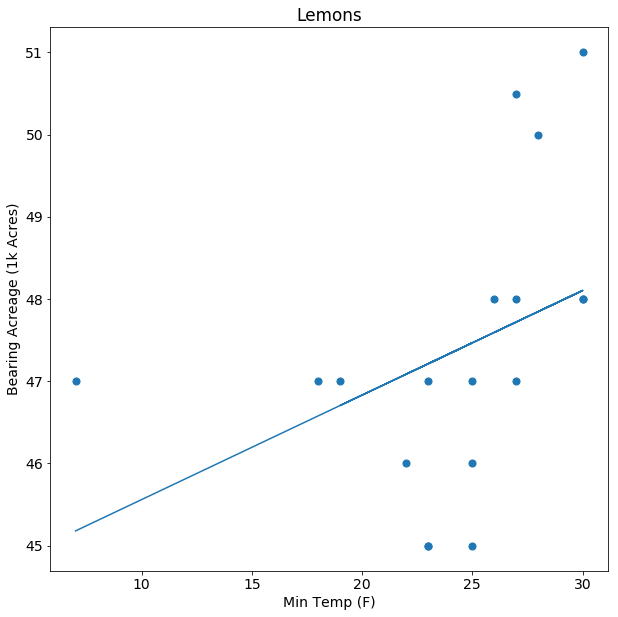

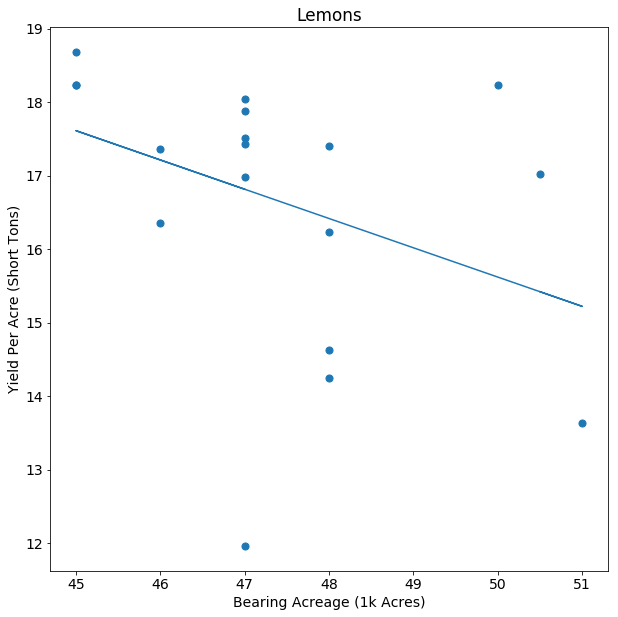

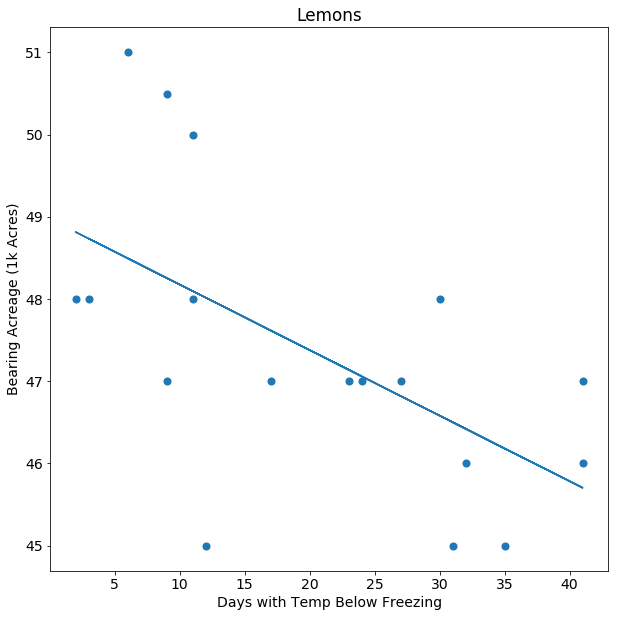

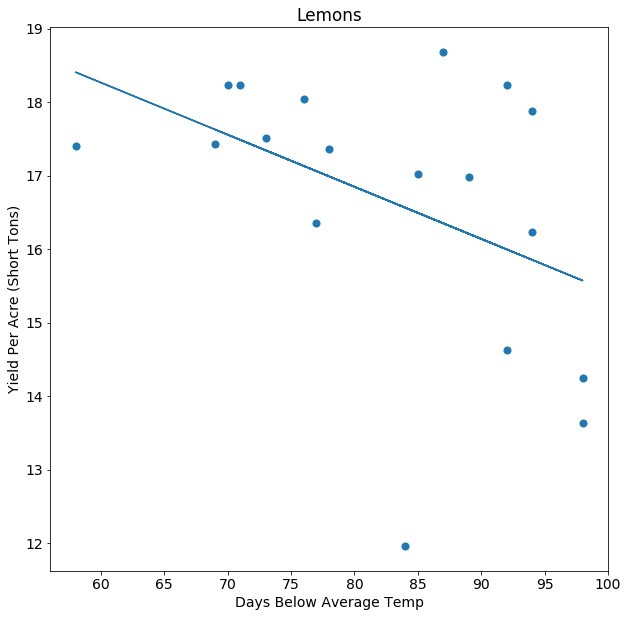

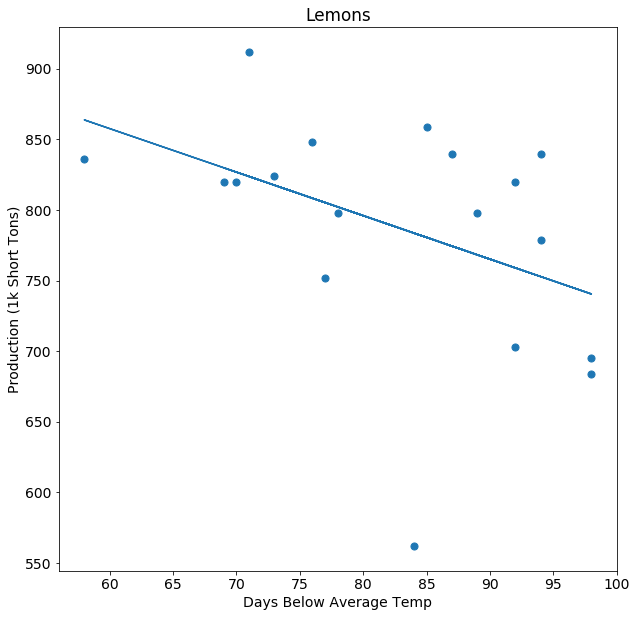

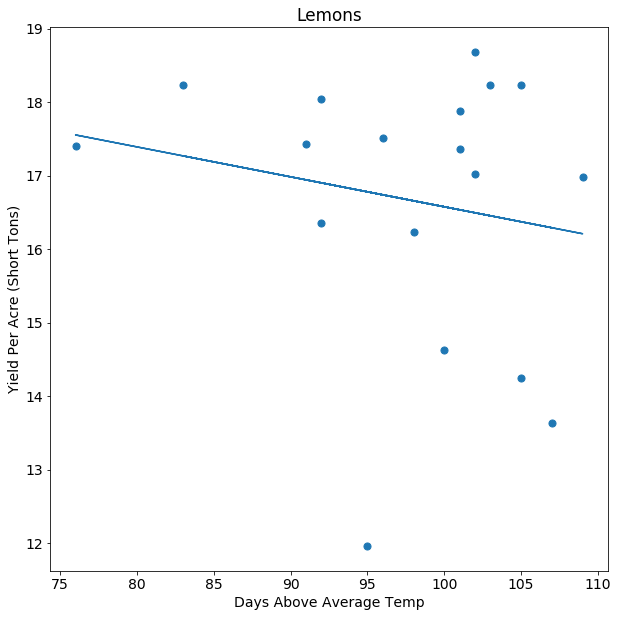

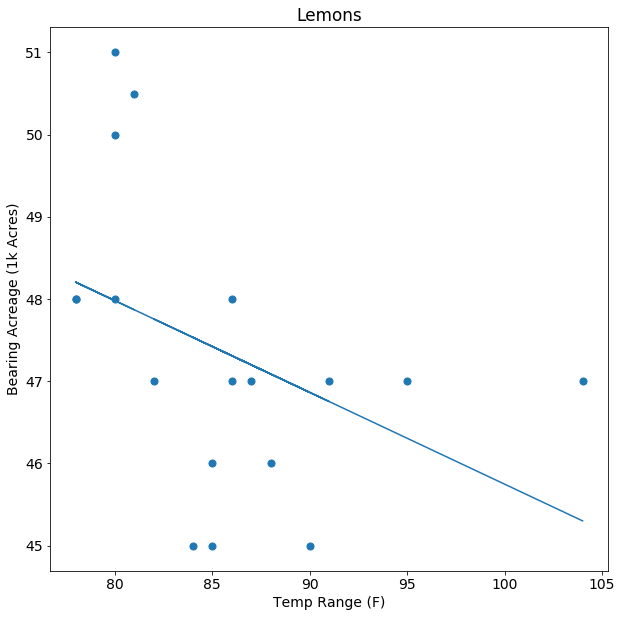

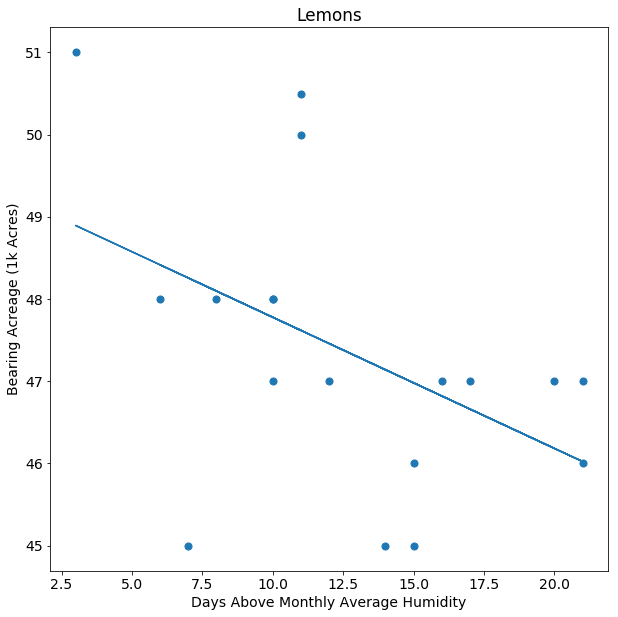

In [24]:
# define a helper method that can generate a scatter plot with a trend line
def scatter_with_trendline(dataframe, x, y, s, c=None, title=None):
    plt.rcParams['figure.figsize'] = (10, 10)
    plt.rcParams['font.size'] = 14
    ax = dataframe.plot.scatter(x=x, y=y, s=s, title=title, c=c)
    z = np.polyfit(list(dataframe[x]), list(dataframe[y]), 1)
    p = np.poly1d(z)
    x_vals = dataframe[x]
    ax.plot(x_vals, p(x_vals), c=c)


scatter_with_trendline(lemons_df, x='Min Temp (F)', y='Bearing Acreage (1k Acres)', s=50, title='Lemons')
scatter_with_trendline(lemons_df, 'Bearing Acreage (1k Acres)', 'Yield Per Acre (Short Tons)', s=50, title='Lemons')
scatter_with_trendline(lemons_df, x='Days with Temp Below Freezing', y='Bearing Acreage (1k Acres)', s=50, title='Lemons')
scatter_with_trendline(lemons_df, x='Days Below Average Temp', y='Yield Per Acre (Short Tons)', s=50, title='Lemons')
scatter_with_trendline(lemons_df, x='Days Below Average Temp', y='Production (1k Short Tons)', s=50, title='Lemons')
scatter_with_trendline(lemons_df, x='Days Above Average Temp', y='Yield Per Acre (Short Tons)', s=50, title='Lemons')
scatter_with_trendline(lemons_df, x='Temp Range (F)', y='Bearing Acreage (1k Acres)', s=50, title='Lemons')
scatter_with_trendline(lemons_df, x='Days Above Monthly Average Humidity', y='Bearing Acreage (1k Acres)', s=50, title='Lemons')

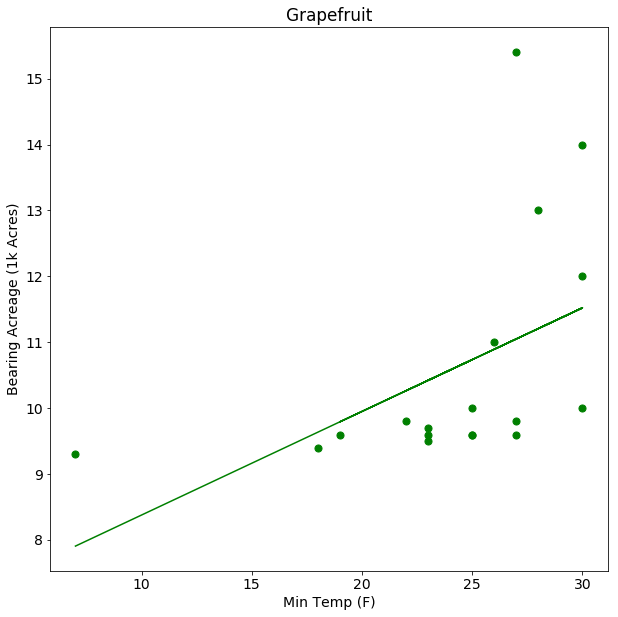

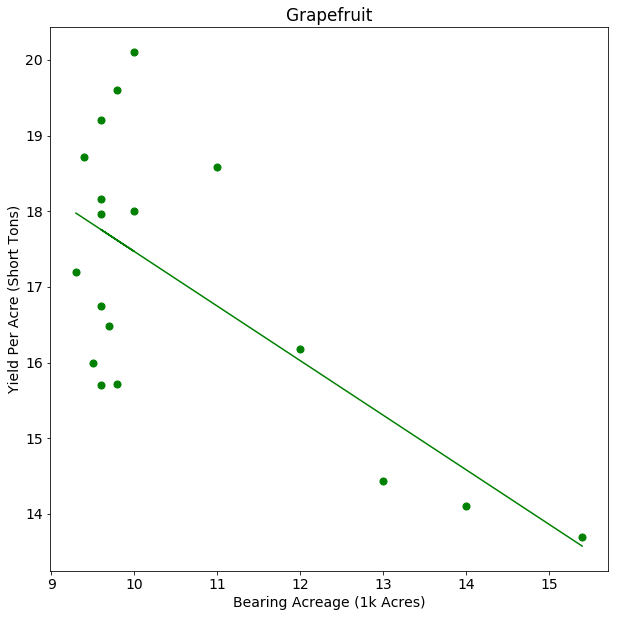

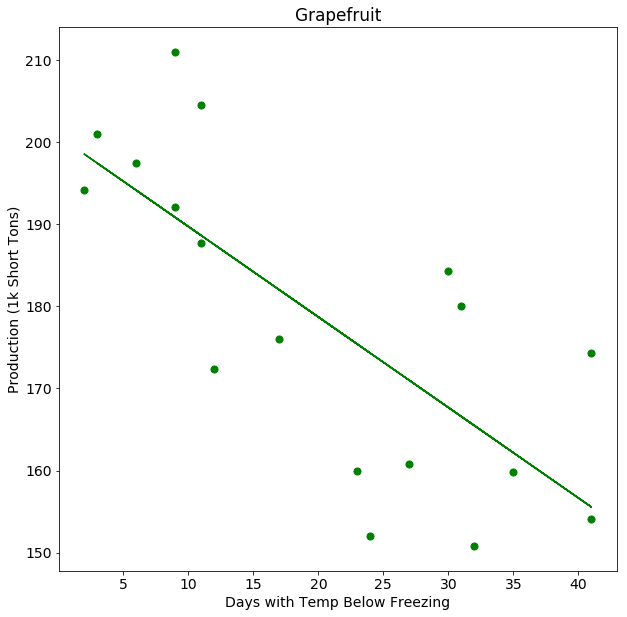

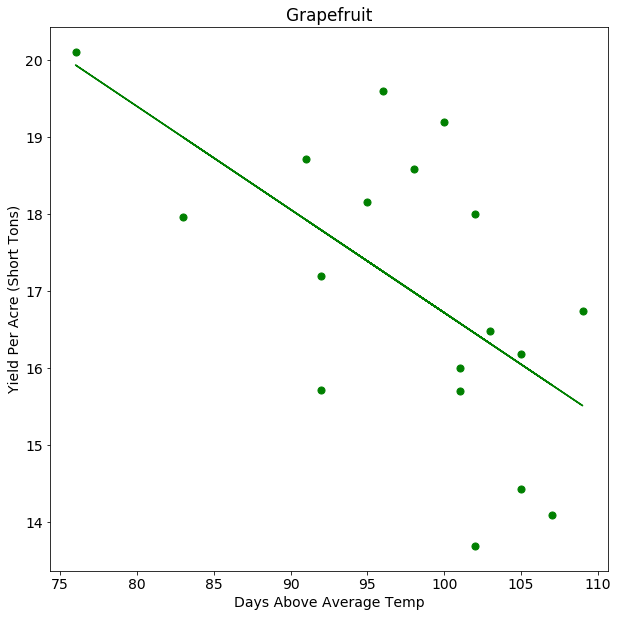

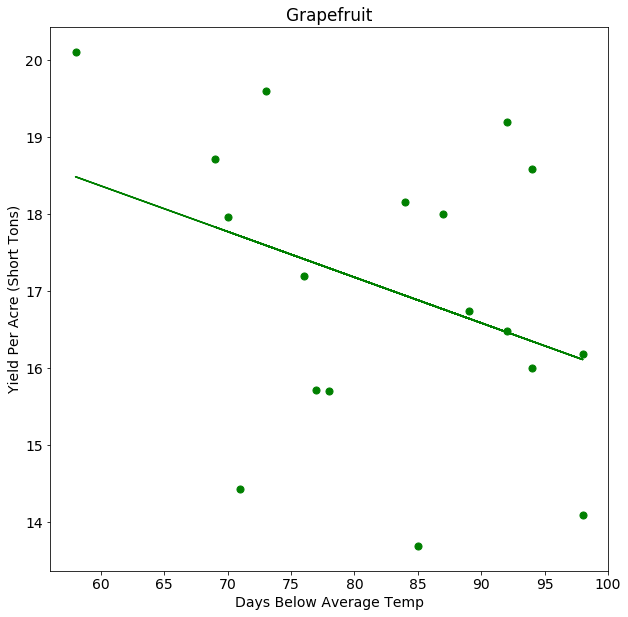

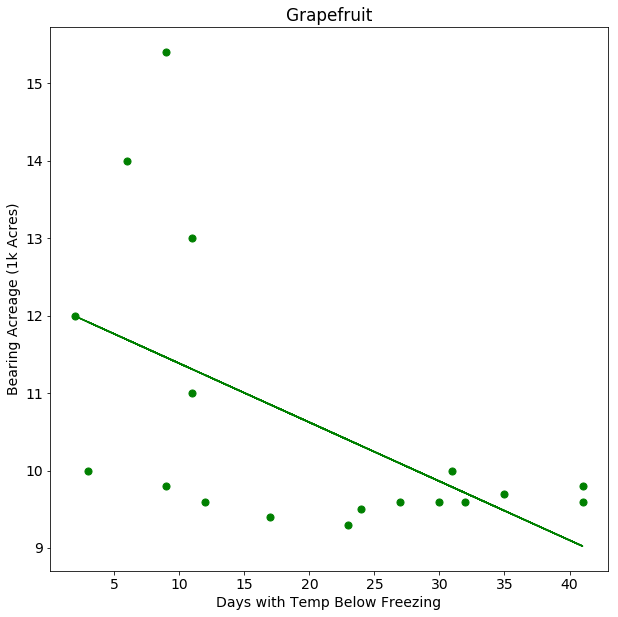

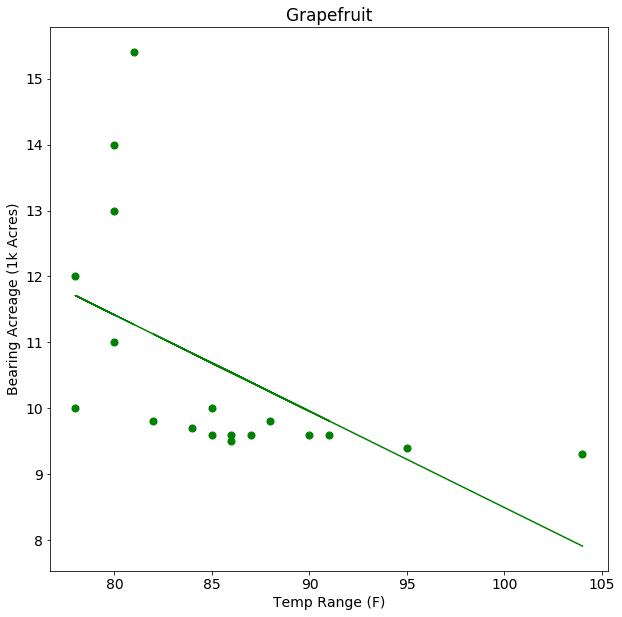

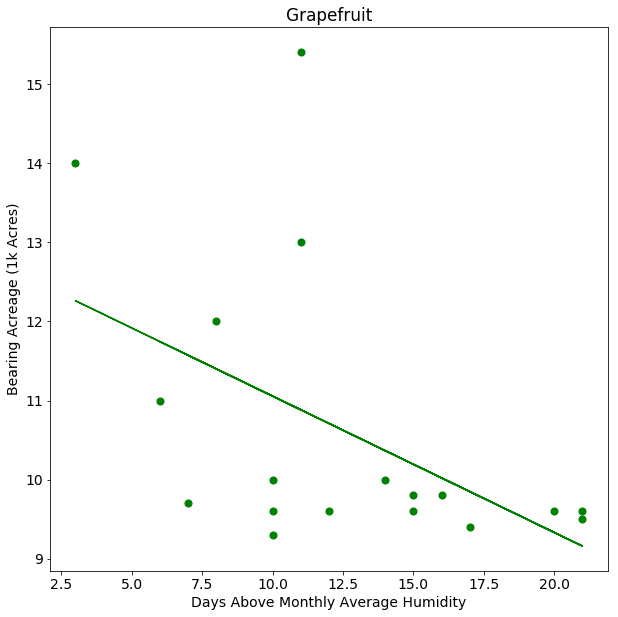

In [25]:
scatter_with_trendline(grapefruit_df, x='Min Temp (F)', y='Bearing Acreage (1k Acres)', s=50, c='green', title='Grapefruit')
scatter_with_trendline(grapefruit_df, x='Bearing Acreage (1k Acres)', y='Yield Per Acre (Short Tons)', s=50, c='green', title='Grapefruit')
scatter_with_trendline(grapefruit_df, x='Days with Temp Below Freezing', y='Production (1k Short Tons)', s=50, c='green', title='Grapefruit')
scatter_with_trendline(grapefruit_df, x='Days Above Average Temp', y='Yield Per Acre (Short Tons)', s=50, c='green', title='Grapefruit')
scatter_with_trendline(grapefruit_df, x='Days Below Average Temp', y='Yield Per Acre (Short Tons)', s=50, c='green', title='Grapefruit')
scatter_with_trendline(grapefruit_df, x='Days with Temp Below Freezing', y='Bearing Acreage (1k Acres)', s=50, c='green', title='Grapefruit')
scatter_with_trendline(grapefruit_df, x='Temp Range (F)', y='Bearing Acreage (1k Acres)', s=50, c='green', title='Grapefruit')
scatter_with_trendline(grapefruit_df, x='Days Above Monthly Average Humidity', y='Bearing Acreage (1k Acres)', s=50, c='green', title='Grapefruit')

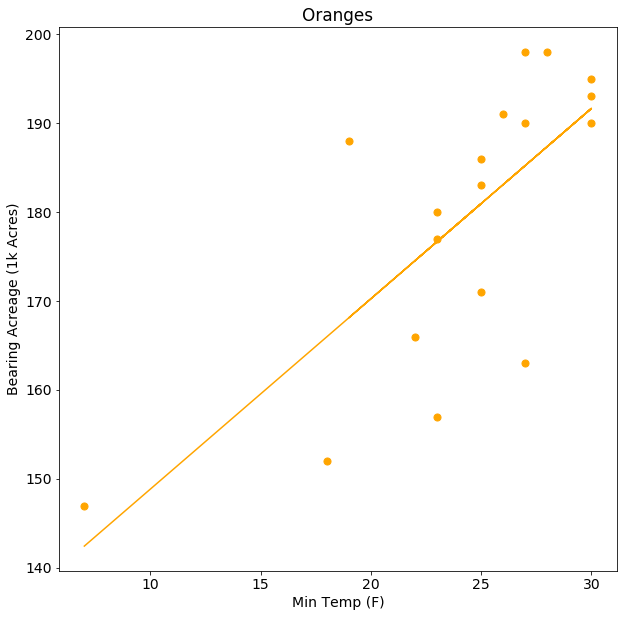

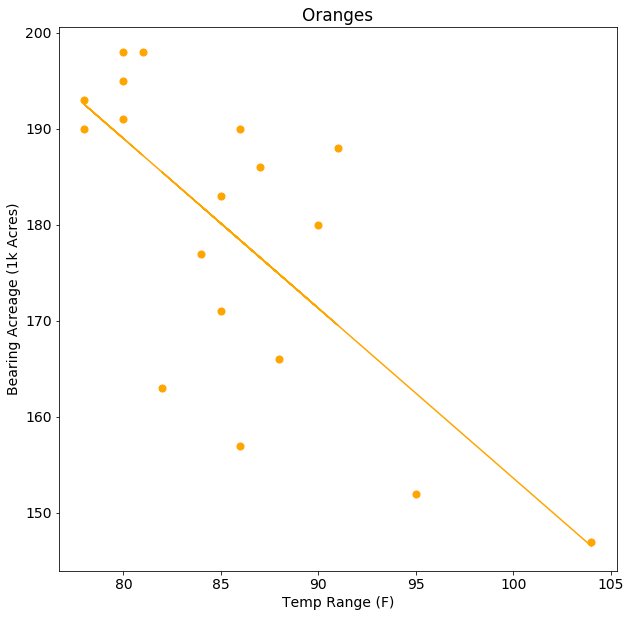

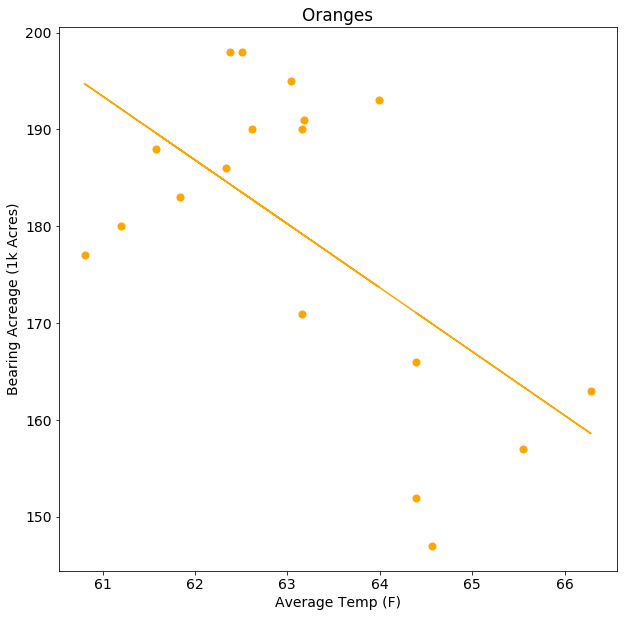

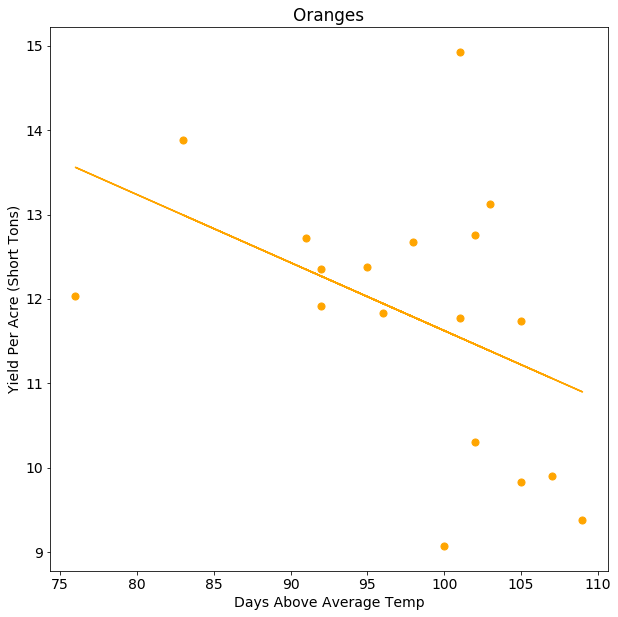

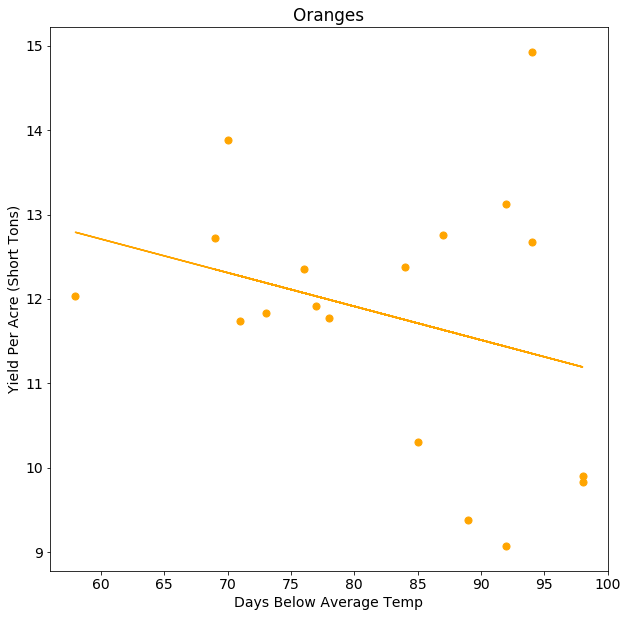

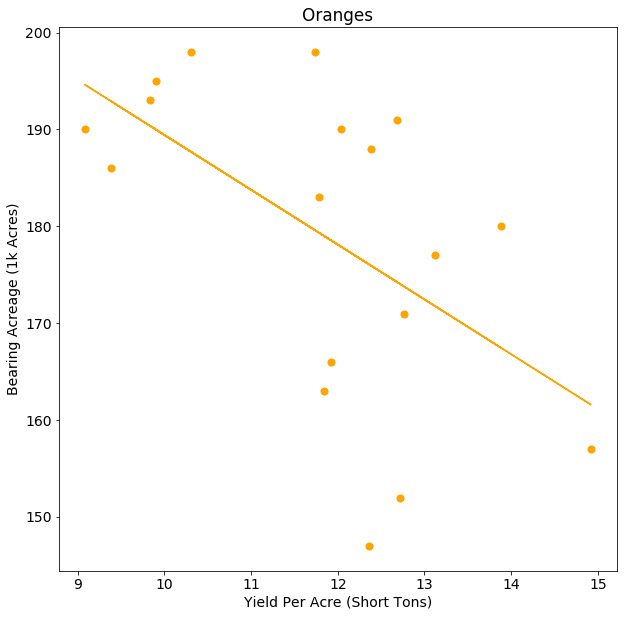

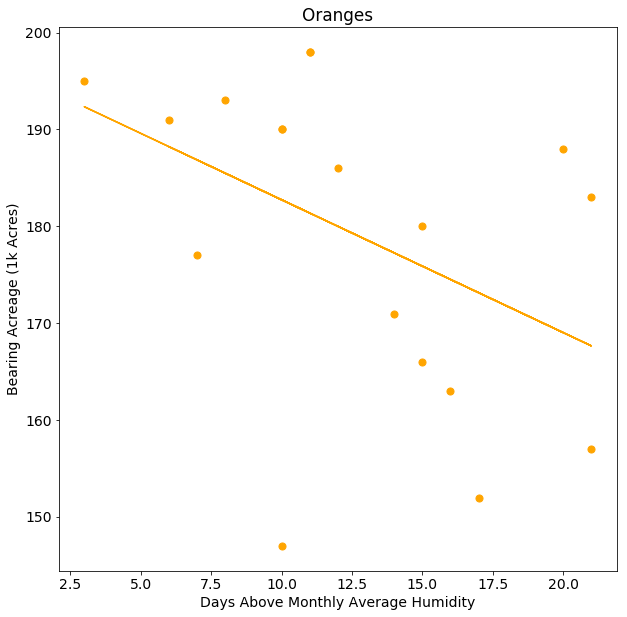

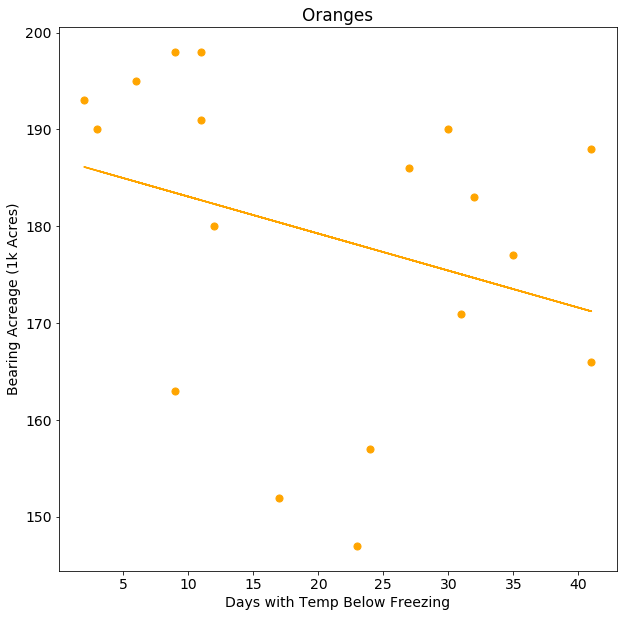

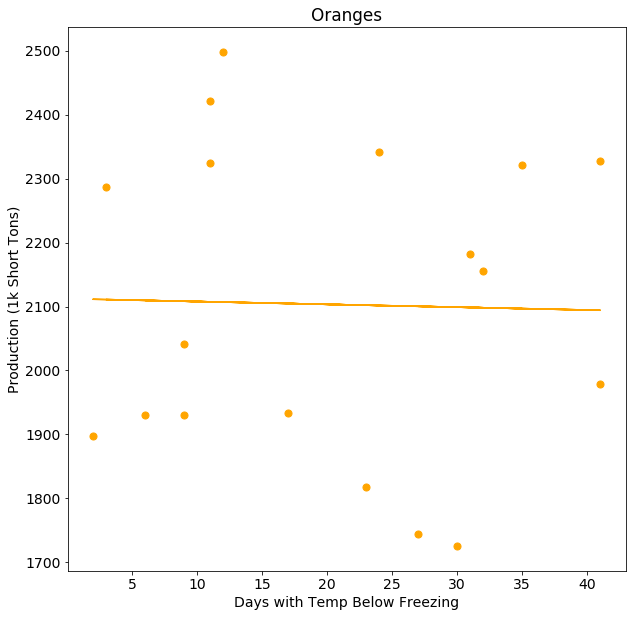

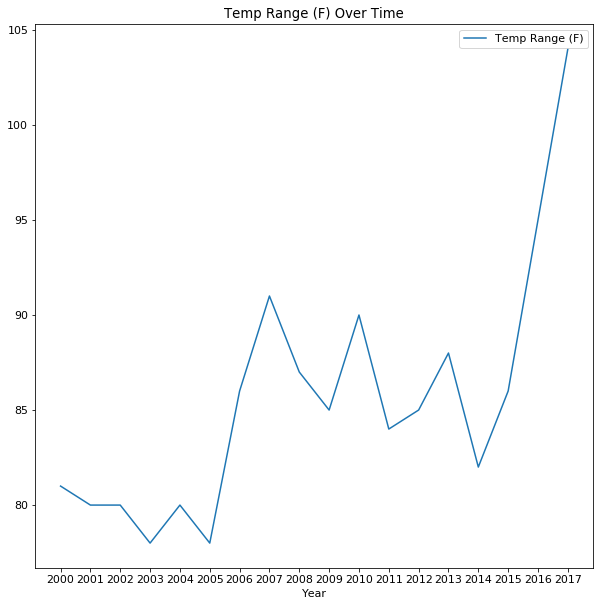

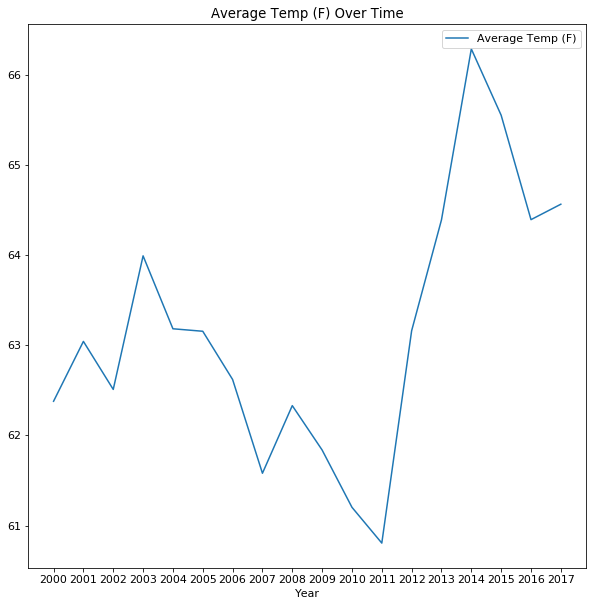

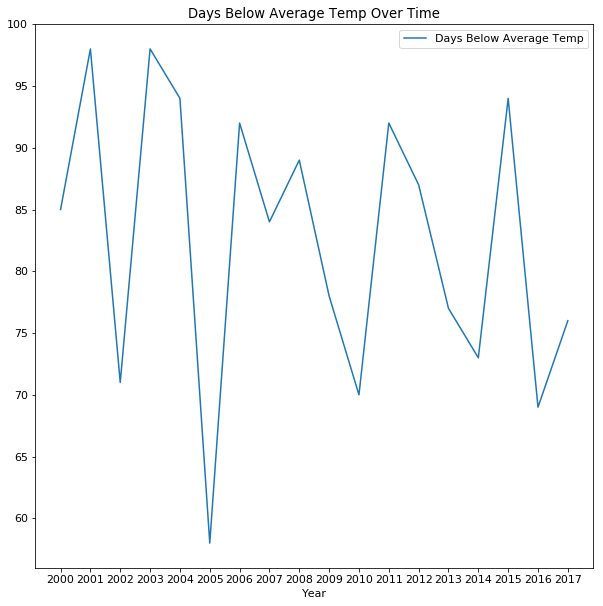

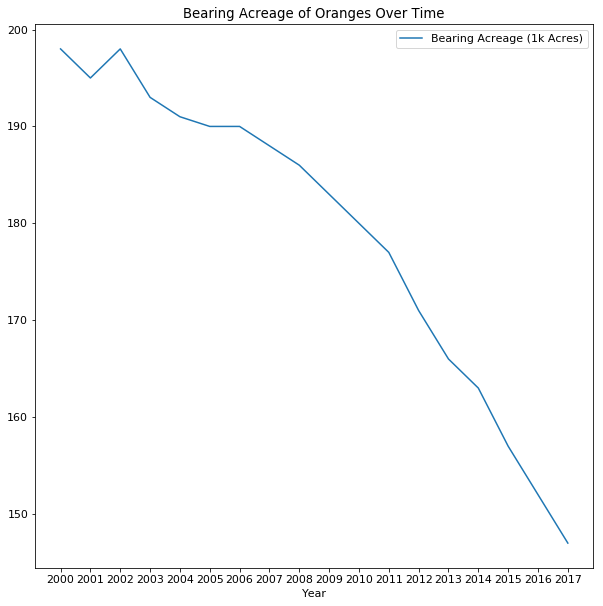

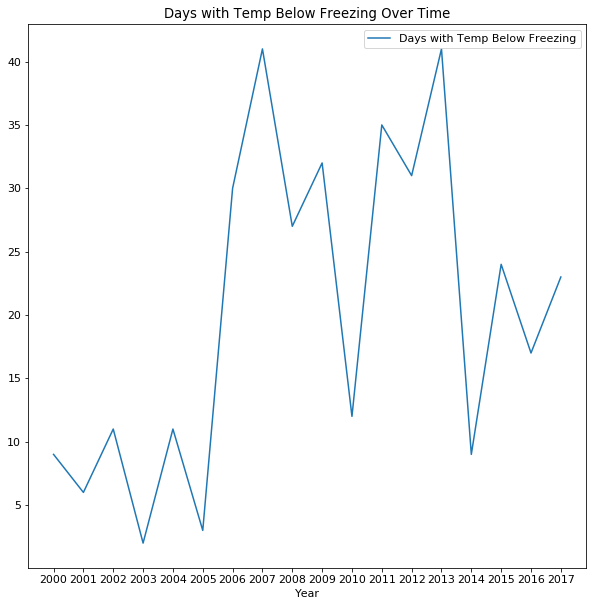

In [26]:
scatter_with_trendline(oranges_df, x='Min Temp (F)', y='Bearing Acreage (1k Acres)', s=50, c='orange', title='Oranges')
scatter_with_trendline(oranges_df, x='Temp Range (F)', y='Bearing Acreage (1k Acres)', s=50, c='orange', title='Oranges')
scatter_with_trendline(oranges_df, x='Average Temp (F)', y='Bearing Acreage (1k Acres)', s=50, c='orange', title='Oranges')
scatter_with_trendline(oranges_df, x='Days Above Average Temp', y='Yield Per Acre (Short Tons)', s=50, c='orange', title='Oranges')
scatter_with_trendline(oranges_df, x='Days Below Average Temp', y='Yield Per Acre (Short Tons)', s=50, c='orange', title='Oranges')
scatter_with_trendline(oranges_df, x='Yield Per Acre (Short Tons)', y='Bearing Acreage (1k Acres)', s=50, c='orange', title='Oranges')
scatter_with_trendline(oranges_df, x='Days Above Monthly Average Humidity', y='Bearing Acreage (1k Acres)', s=50, c='orange', title='Oranges')
scatter_with_trendline(oranges_df, x='Days with Temp Below Freezing', y='Bearing Acreage (1k Acres)', s=50, c='orange', title='Oranges')
scatter_with_trendline(oranges_df, x='Days with Temp Below Freezing', y='Production (1k Short Tons)', s=50, c='orange', title='Oranges')

plt.rcParams['font.size'] = 11
# Some time series plots to show trends over time in some of the temperature/humidity metrics
oranges_df.plot.line(x='Year', y='Temp Range (F)', xticks=years, title='Temp Range (F) Over Time')
oranges_df.plot.line(x='Year', y='Average Temp (F)', xticks=years, title='Average Temp (F) Over Time')
oranges_df.plot.line(x='Year', y='Days Below Average Temp', xticks=years, title='Days Below Average Temp Over Time')
oranges_df.plot.line(x='Year', y='Bearing Acreage (1k Acres)', xticks=years, title='Bearing Acreage of Oranges Over Time')
oranges_df.plot.line(x='Year', y='Days with Temp Below Freezing', xticks=years, title='Days with Temp Below Freezing Over Time')

## Hypothesis Testing - Pearson's Correlation Statistic

We performed hypothesis testing to try and validate the observed linear relationships between some of the weather and agricultural variables analyzed above. Our null hypotheses in all cases were that there is no linear relationship between each pair of weather and agricultural variables that we looked at. The test statistic that we used to test the null hypotheses was the Pearson's correlation coefficient. Under the assumption that the null hypothesis is true, we used a p-value of 0.05 to determine statistical significance. All p-values were generated via the `scipy.stats` package's built in `pearsonr()` function.

### Days with Below Freezing Temperatures vs. Production

When looking at the linear relationship between the number of days with below freezing temperatures in a year, and production measured in 1k short tons, we observed a strong negative correlation in grapefruit, a moderate negative correlation in lemons, and a weak negative correlation in oranges. When looking at the p-values, we see that this linear relationship is only statistically significant in grapefruit, which had a p-value of 0.0004. The p-values for oranges and lemons on the other hand were 0.9266 and 0.2736 respectively, indicating a failure to reject the null hypothesis that there is no linear relationship between these two variables in these crops. One would think that this is indicative of grapefruits being biologically less cold hardy than other citrus varieties, however our literature review has [indicated otherwise.](https://aggie-horticulture.tamu.edu/newsletters/hortupdate/2011/mar/citrus_freeze.html). However, oranges are considered to be somewhat more cold hardy than other fruits, requiring temperatures in the mid-20s before damage is incurred, which aligns with the lack of a strong linear relationship observed between freezing temperatures and production in this corp. Another possibility is that perhaps the orange and lemon farms whose data was collected by the USDA had employed countermeasures that allowed them to mitigate the effects of these extremes in cold on their crops, whereas the grapefruit farms did not. Fine grained data at the county and farm level would be required to validate and test this hypothesis though, which points to a potential direction for future study in this area.

### Days with Below Freezing Temperatures vs. Bearing Acreage

When looking at the potential linear relationship between the number of days with below freezing temperatures, and bearing acreage measured in 1k acres, we had observed moderate negative Pearson's correlations across all three citrus crops. When looking at the p-values, we saw that this relationship is only statistically valid in grapefruits and lemons, with p-values of 0.0186 and 0.0109 respectively. The p-value for oranges was 0.2181, indicating a failure to reject the null hypothesis that there is no linear relationship between these two variables in oranges. As highlighted previously, oranges are considered to be one of the more cold hardy citrus varieties, which might explain the lack of a statistically significant negative linear relationship between freezing temperatures and bearing acreage in this crop.

### Temperature Range vs. Bearing Acreage

When looking at the potential linear relationship between the yearly temperature range (max fahrenheit - min fahrenheit) and bearing acreage, we had observed a strong negative correlation in oranges, and moderate negative correlations in grapefruits and lemons. When looking at the p-values, we see that this relationship is only statistically significant in grapefruits and oranges, which had p-values of 0.0223 and 0.0007. The p-value for lemons was 0.0866, indicating a failure to reject the null hypothesis that there is no linear relationship between this two variables with regards to lemons.

### Minimum Temperature vs. Bearing Acreage

When looking at the potential linear relationship between the minimum yearly temperature in fahrenheit and the bearing acreage, we had observed a strong positive correlation in oranges, and moderate positive correlations in grapefruits and lemons. When looking at the p-values, we again see that this relationship is statistically significant in grapefruits and oranges, with p-values of 0.0425 and 0.0006 respectively, while not statistically significant in lemons, which had a p-value of 0.1032. This is to be expected after having seen similar results for temperature range, as temperature range is just a linear function of minimum temperature. In general, we would expect that as minimum yearly temperature goes up (indicating a less extreme low), the bearing acreage for the citrus crops in the respective season would be higher. The lack of a statistically significant relationship in lemons in conjunction with there being significant results for oranges and grapefruits might simply be indicative of noise in the data, lack of enough data points (the time series we looked at only spans 18 years), or the way that we joined the weather data with the agricultural data. Further exploration and slicing of the data is required to tease apart the complex and multifaceted interactions between the weather and agricultural variables that we analyzed.

### Number of Days with Below Average Temperatures vs Yield Per Acre

When looking at the potential linear relationship between the number of days with average temperatures below the yearly average, and yield per acre, we had observed weak negative correlations between these two variables with respect to all three citrus crops. We also saw that this relationship is not statistically significant in grapefruits, oranges, nor in lemons, which had p-values of 0.1426, 0.2400, and 0.0690 respectively, indicating a failure to reject our null hypothesis across the board.

### Number of Days with Above Average Temperatures vs Yield Per Acre

When looking at the potential linear relationship between yield per acre, and the number of days with average temperatures above the yearly average, we observed weak-to-strong negative correlations in all three citrus crops. When looking at the p-values, we see that this relationship is only statistically significant in grapefruits, which had a p-value of 0.0087. Oranges and lemons on the other hand had p-values of 0.0717 and 0.4615 respectively, indicating a failure to reject the null hypothesis that there is no linear relationship between these two variables with respect to these crops. While we only saw a statistically significant relationship in grapefruits, the existence of these negative relationships indicates that yield per acre in citrus could potentially be negatively effected by extreme highs in temperature, in addition to extreme lows. Such declines in yield per acre might potentially be due to damage caused by dessication or heat stress under high temperature regimes, but more analysis and data collection is needed to validate this hypothesis.


### Bearing Acreage vs. Yield Per Acre

When looking at bearing acreage vs. yield per acre in the three citrus crops, we observed moderate to strong negative correlations between these two variables in all three. However, when looking at the p-values, we see that this relationship is only statistically significant in grapefruit and oranges, with p-values of 0.0018 and 0.0178 respectively. When looking at the relationship between these two variables in lemons, we see a p-value of only 0.1225, indicating a failure to reject the null hypothesis, that there is no linear relationship between these two variables in lemons. The presence of this linear relationship came as a surprise to us, and has led to the development of more hypotheses that we would like to explore in a future study. One hypothesis for this observed negative relationship between bearing acreage and yield per acre, is that perhaps as citrus farms are scaling back their bearing acreage, they are better able to utilize and tend to the producing acreage that they alread have, which is leading to an increase the the measured yield per acre. As the USDA data is aggregated, and does not reveal such fine grained details, more data collection at the county and farm level would be needed to explore and test this hypothesis.

### Issues

One issue that we had with attempting to evaluate the linear relationship between freezing temperatures and production in this study, is that production is a component not only of bearing acreage, but also yield per acre. The weather data that we collected spans the calendar year, whereas the agricultural data, while yearly, actually corresponds to the production season for each crop. Orange and grapefruit season does not start until November in California, and lemon season starts in August. Therefore, to better quantify the effects of temperature anomalies on yield per acre, which is more dependent upon recent fluctuations in weather, we would need to reagreggate the weather data into seasonal aggregates, to potentially see stronger relationships between weather variables and yield per acre.

Another issue with using a statistic like number of days with below freezing temperatures as a proxy for extremes in cold, is that it does not provide any information as to the duration of time during which those freezing temperatures occured within a day. Since we generated this statistic by just counting the number of days that had a minimum temperature below freezing, and did not look at the span of hours within the day that had these extreme lows, we missed out on a lot of important information. Citrus crops will be damaged by extreme lows, but that damage will be more prone to manifesting if those extremes in temperature occur over an extended period of time without a break. We had attempted to capture this information by looking at the number of days in a year with temperatures close to their monthly extreme, in months that had extreme temperatures, but this is also a bad metric in hindsight, because only a few months out of an average year would be expected to have extreme lows (below freezing), and when looking at the relationship between this variable and production, we observed weak correlations across all three crops.


In [27]:
from scipy.stats import *

def get_p_value_for_correlation(dataframe, x, y):
    
    xs = list(dataframe[x])
    ys = list(dataframe[y])
    
    corr, p_val = pearsonr(dataframe[x], dataframe[y])
    
    return p_val

data_frames = [grapefruit_df, oranges_df, lemons_df]

ba_vs_ypa = []
for df in data_frames:
    ba_vs_ypa.append(get_p_value_for_correlation(df, 'Bearing Acreage (1k Acres)', 'Yield Per Acre (Short Tons)'))

days_temp_below_32_vs_prd = []
for df in data_frames:
    days_temp_below_32_vs_prd.append(get_p_value_for_correlation(df, 'Days with Temp Below Freezing', 'Production (1k Short Tons)'))
    
days_temp_below_32_vs_ba = []
for df in data_frames:
    days_temp_below_32_vs_ba.append(get_p_value_for_correlation(df, 'Days with Temp Below Freezing', 'Bearing Acreage (1k Acres)'))

temperature_range_vs_ba = []
for df in data_frames:
    temperature_range_vs_ba.append(get_p_value_for_correlation(df, 'Temp Range (F)', 'Bearing Acreage (1k Acres)'))

min_temperature_vs_ba = []
for df in data_frames:
    min_temperature_vs_ba.append(get_p_value_for_correlation(df, 'Min Temp (F)', 'Bearing Acreage (1k Acres)'))

days_below_yearly_vs_ypa = []
for df in data_frames:
    days_below_yearly_vs_ypa.append(get_p_value_for_correlation(df, 'Days Below Average Temp', 'Yield Per Acre (Short Tons)'))

days_above_yearly_vs_ypa = []
for df in data_frames:
    days_above_yearly_vs_ypa.append(get_p_value_for_correlation(df, 'Days Above Average Temp', 'Yield Per Acre (Short Tons)'))

print(ba_vs_ypa)
print(days_temp_below_32_vs_prd)
print(days_temp_below_32_vs_ba)
print(temperature_range_vs_ba)
print(min_temperature_vs_ba)
print(days_below_yearly_vs_ypa)
print(days_above_yearly_vs_ypa)



[0.0018262091122600093, 0.01785776142635091, 0.12251883403253777]
[0.0004457437559023655, 0.9266231103336036, 0.2736505008955258]
[0.018610217250335293, 0.21810879702382374, 0.010964216316856592]
[0.022323858684620945, 0.0007903076489887911, 0.08666653236105563]
[0.042584191786065734, 0.0006078378152309128, 0.10329676847982237]
[0.14260459728556502, 0.24002901795358317, 0.06900780786844093]
[0.008713363100271727, 0.07178746127447581, 0.4615216377892354]
